# 목차
1. 개요

2. 데이터 탐색

3. 데이터 전처리

4. 데이터 스케일링 & 리샘플

5. 피처셀렉션

6. 통계 검증

7. 모델링&성능평가

# 1. 개요
## ◆ Lending Club Defualt Detection

- 프로젝트 목표 : 부도 예측 모형 성능 최적화 및 고객 등급화



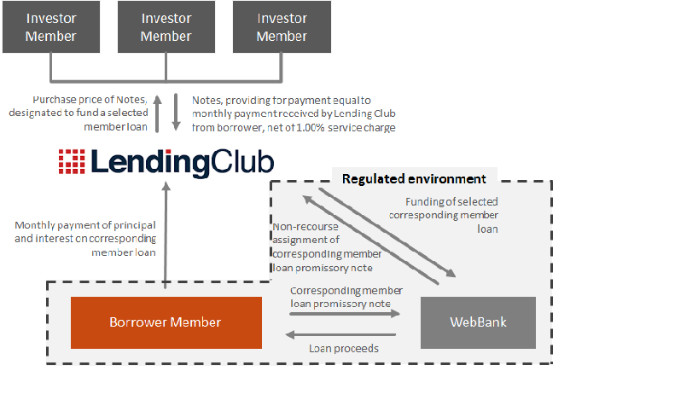

- LendingClub은 미국 P2P 대출 회사로 기존 대출 방식이 1:1이 아닌 多:1의 funding 형태로 이루어진다.
- LendingClub은 기존 은행 대출과 다르게 부도리스크를 직접 부담하지 않는다.
- 그럼에도 부도리스크를 관리해야 하는 이유? : 고객의 리스크 관리가 플랫폼의 경쟁력과 직결
- 2015년, 2016년 데이터 : 2016년 부실대출 사태 -> 고객의 신뢰도 하락

http://journal.dcs.or.kr/xml/20578/20578.pdf

## 분석 요약

- Task : Lending Club Defualt Detection (Classification)

- Data : Lending Club Data (2260701 rows × 151 columns)

- Tools : Python

- Model : LGBMClassifier

- Evaluation Metric : AUC

In [ ]:
# 사용 라이브러리
import pandas as pd
import numpy as np

# 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

# 통계
from scipy import stats
import statsmodels.api as sm

# 리샘플
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours

# 모델
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
# from pytorch_tabnet.tab_model import TabNetClassifier
# from catboost import CatBoostClassifier


# 평가 지표
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, fbeta_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# data load
path = '/content/drive/MyDrive/Colab Notebooks/accepted_2007_to_2018Q4.csv'
df = pd.read_csv(path, low_memory=False)

# 2. 데이터 탐색

## 데이터 구성 확인

In [ ]:
# 2260701 rows × 151 columns
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2260701 rows × 151 columns 형태로 이루어진 데이터

151개의 컬럼을 선별하는 방식의 고민이 필요할 것으로 예상

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


float64(113), object(38)

38개의 오브젝트 변수 처리 필요

In [ ]:
df[['id','issue_d','loan_status', 'application_type']]

,id,issue_d,loan_status,application_type
0,68407277,Dec-2015,Fully Paid,Individual
1,68355089,Dec-2015,Fully Paid,Individual
2,68341763,Dec-2015,Fully Paid,Joint App
3,66310712,Dec-2015,Current,Individual
4,68476807,Dec-2015,Fully Paid,Individual
...,...,...,...,...
2260696,88985880,Oct-2016,Current,Individual
2260697,88224441,Oct-2016,Charged Off,Individual
2260698,88215728,Oct-2016,Current,Individual
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN


## 주요 데이터 확인

id : Key 데이터

.

issue_d	: 대출 실행년월 -> 모든 년도의 데이터를 활용할 것 인가?

.

loan_status	: ['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off']

-> label 데이터, 확실한 부도 측정을 위해 'In Grace Period', nan, 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off' 데이터는 제외하도록 한다.

.

application_type : ['Individual', 'Joint App', nan]

-> 'Joint App' 즉, 공동 신청자 대출 데이터와 개인 신청자의 데이터 형태가 달라

공동 신청자 데이터를 분석에서 제외

In [ ]:
df['application_type'].unique()

array(['Individual', 'Joint App', nan], dtype=object)

## 타겟 정의

In [ ]:
# 타겟 정의

# 'loan_status' 대출현황 - label
print(df['loan_status'].unique(), df['loan_status'].nunique())

# 'Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default' 만 남기고 제거
df = df[df['loan_status'].isin(['Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default'])]

# 'Fully Paid' and 'Current' = 0, 'Charged Off' and 'Late (31-120 days)' and 'Late (16-30 days)' and 'Default' = 1
df['Y'] = df['loan_status'].map({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1, 'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'Default': 1})

# 확인
print(df['Y'].unique(), df['Y'].nunique(), df['Y'].dtype)

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off'] 9
[0 1] 2 int64


<ipython-input-7-16fe2cda09c9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Y'] = df['loan_status'].map({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1, 'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'Default': 1})


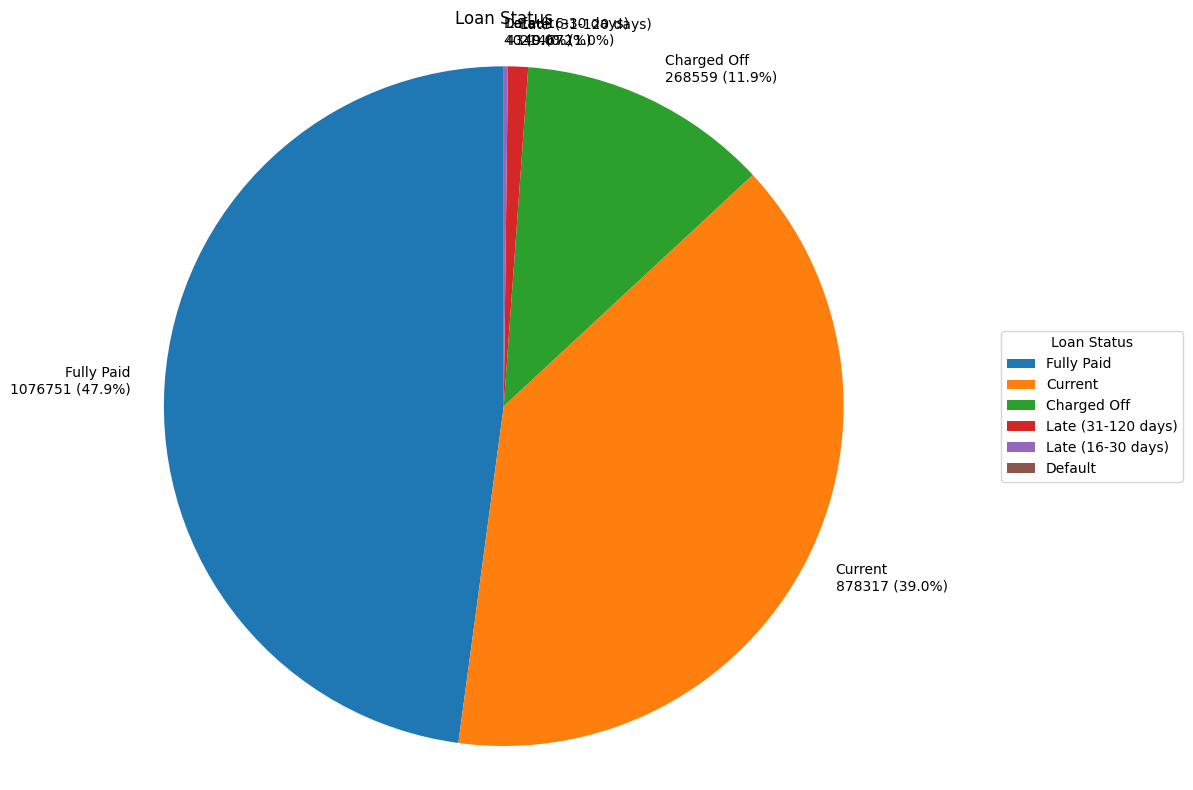

In [ ]:
# loan_status의 개수와 비율 계산
loan_status_counts = df['loan_status'].value_counts()
loan_status_percentages = loan_status_counts / len(df) * 100

# 레이블 생성 (카테고리명, 개수, 비율)
labels = [f'{index}\n{count} ({percentage:.1f}%)'
          for index, count, percentage in
          zip(loan_status_counts.index, loan_status_counts, loan_status_percentages)]

# 원그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(loan_status_counts, labels=labels, autopct='', startangle=90)
plt.title('Loan Status')
plt.axis('equal')

# 범례 추가
plt.legend(loan_status_counts.index, title="Loan Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

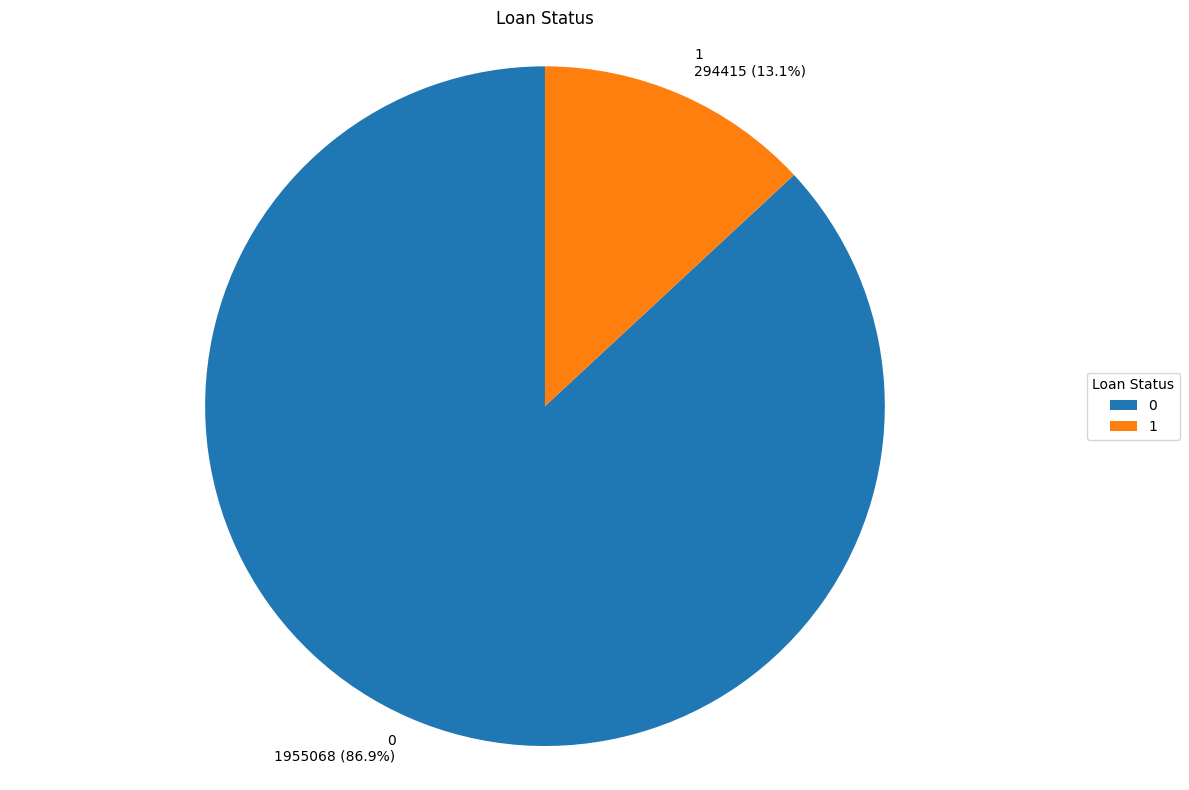

In [ ]:
# loan_status의 개수와 비율 계산
loan_status_counts = df['Y'].value_counts()
loan_status_percentages = loan_status_counts / len(df) * 100

# 레이블 생성 (카테고리명, 개수, 비율)
labels = [f'{index}\n{count} ({percentage:.1f}%)'
          for index, count, percentage in
          zip(loan_status_counts.index, loan_status_counts, loan_status_percentages)]

# 원그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(loan_status_counts, labels=labels, autopct='', startangle=90)
plt.title('Loan Status')
plt.axis('equal')

# 범례 추가
plt.legend(loan_status_counts.index, title="Loan Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

데이터의 비율이 약 87:13

불균형 데이터의 형태

## 대출현황

<ipython-input-10-fb6b72bdf210>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['year'] = pd.to_datetime(df['issue_d']).dt.year
<ipython-input-10-fb6b72bdf210>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['issue_d']).dt.year
<ipython-input-10-fb6b72bdf210>:2: FutureWarning: The provided callable <function sum at 0x7aba7c5f8670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_year_sum=df.groupby(by=['year'], as_index=False).agg({'funded_amnt':np.s

Text(0, 0.5, 'Amount of loans by year')

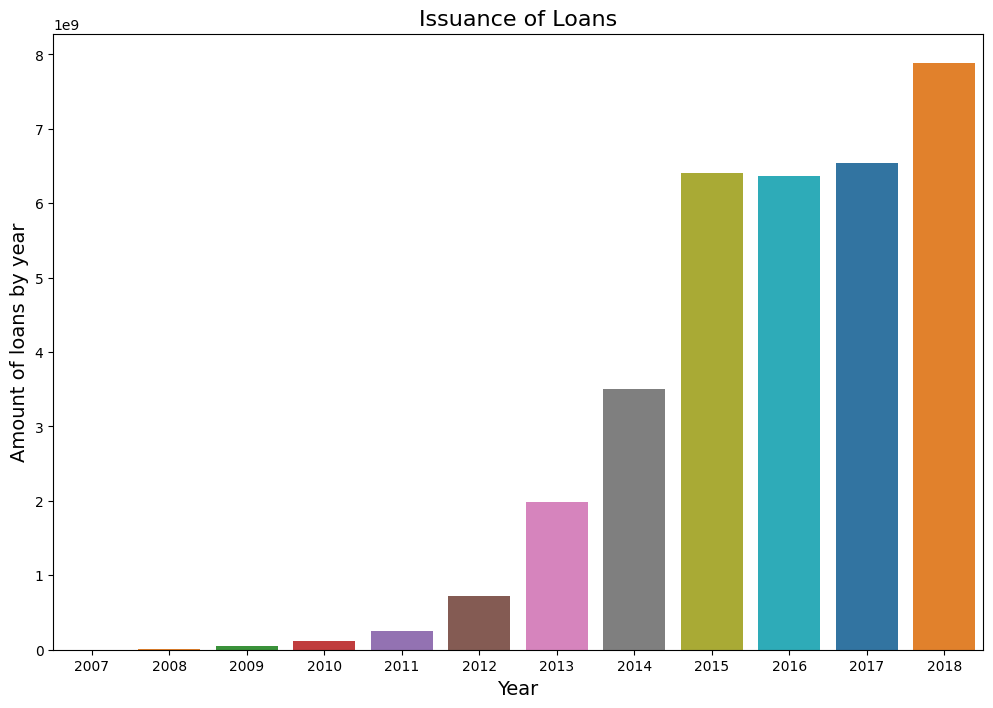

In [ ]:
df['year'] = pd.to_datetime(df['issue_d']).dt.year
df_year_sum=df.groupby(by=['year'], as_index=False).agg({'funded_amnt':np.sum})

# 연도별, 대출금액 추이

plt.figure(figsize=(12,8))
sns.barplot(x='year', y='funded_amnt', data=df_year_sum, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount of loans by year', fontsize=14)

In [ ]:
df['addr_state'].unique()

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'



df['region'] = df['addr_state'].apply(finding_regions)

<ipython-input-11-f91c7277f55c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'] = np.nan
<ipython-input-11-f91c7277f55c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'] = df['addr_state'].apply(finding_regions)


Text(0.5, 1.0, 'Loans issued by Region')

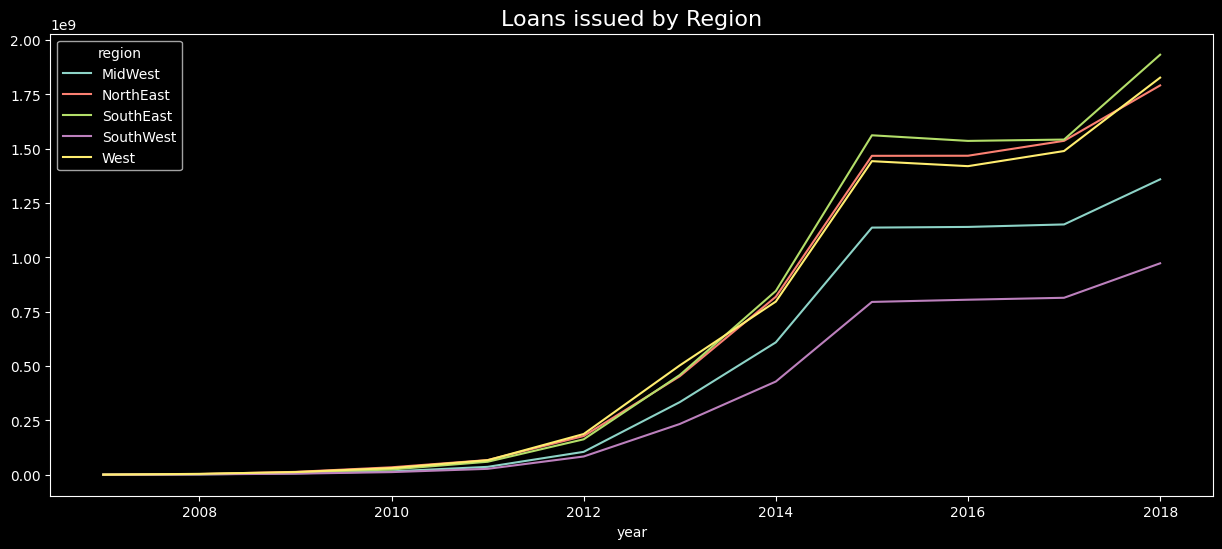

In [ ]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df.groupby(['year', 'region']).funded_amnt.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

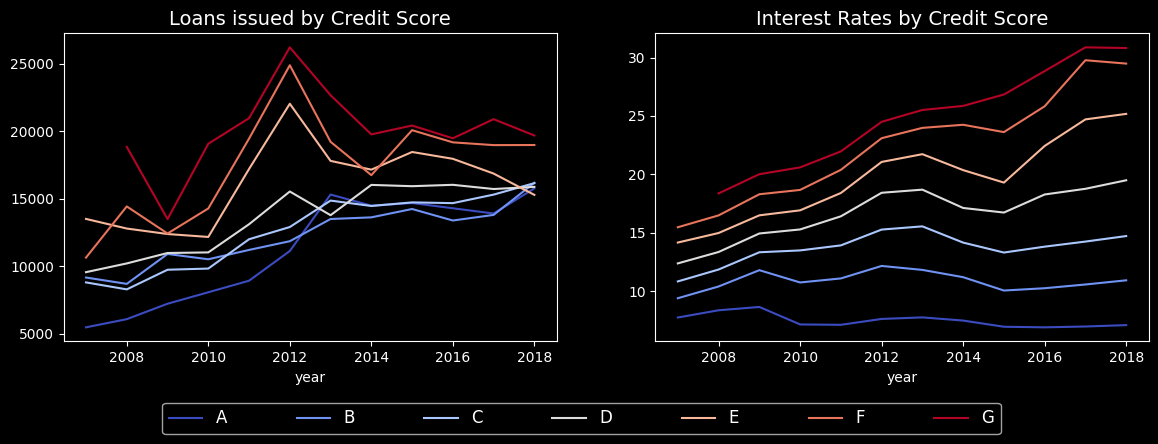

In [ ]:
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).funded_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)


by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

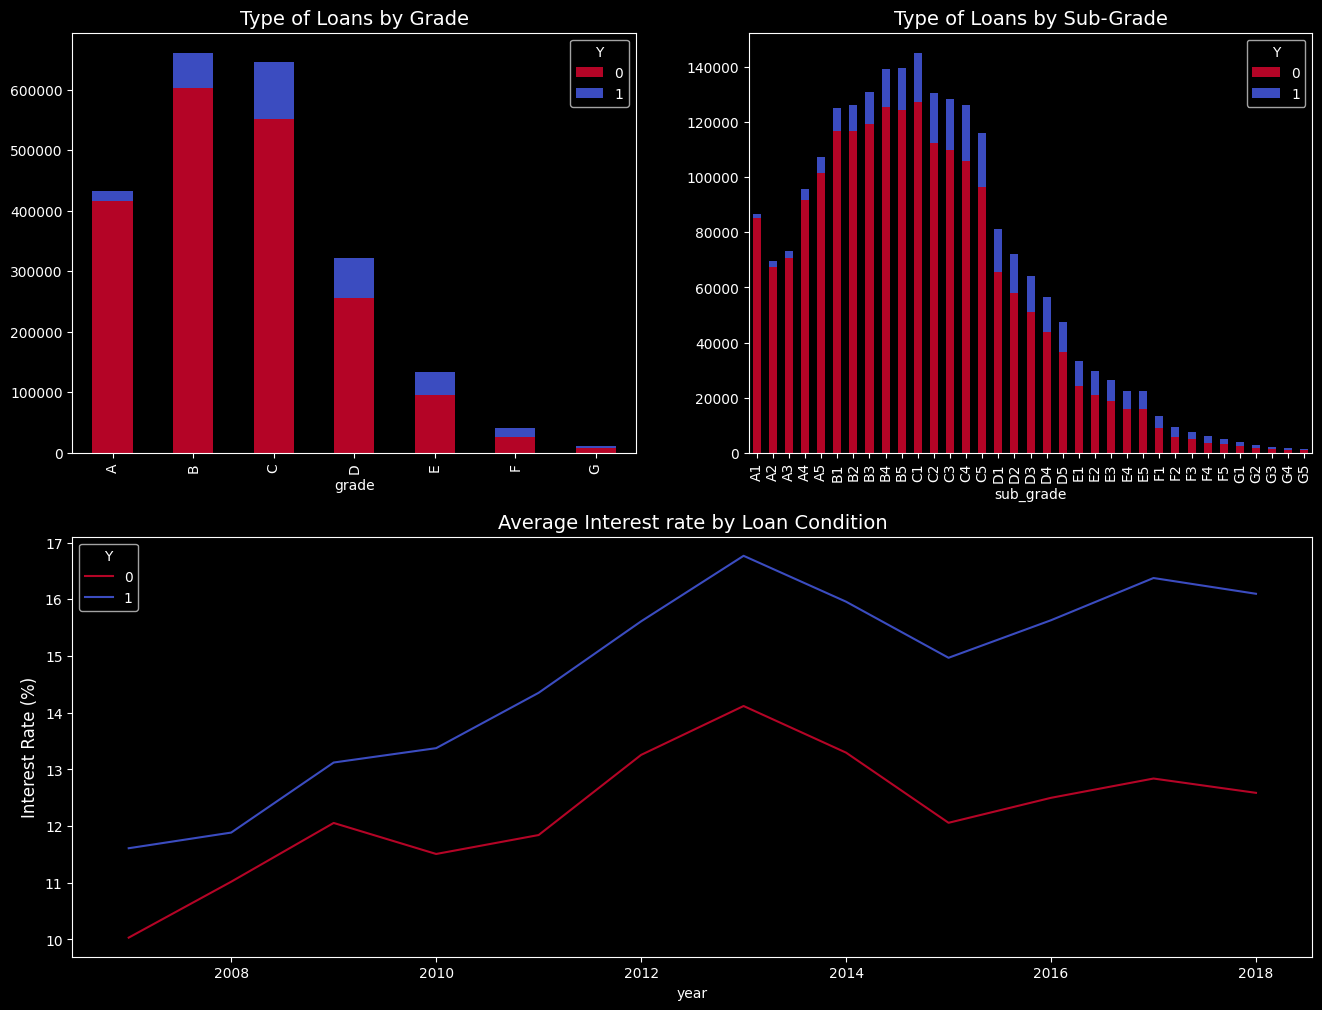

In [ ]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'Y']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'Y']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'Y']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

# 데이터 전처리

## 제외 변수
- 변수의 속성을 확인하고 Target Leakage/Look ahead bias의 가능성, 식별 변수 등 분석에 부적합한 변수 제외

- 크게 3가지 기준 :

1. 신용등급/점수와 직접적인 관련성을 가진 변수

2. 현재 상환 능력을 알수있는 직접적인 금액/채무 관련 변수

3. 식별/자유형식 텍스트 데이터 등 분석에 무의미한 변수

- 상세 이유는 Excel을 통해 확인 가능

- Excel 파일로 정리한 rule 데이터와 결합하여 사용 변수만 남김

In [ ]:
rule = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/LendingClub_데이터_지표_설명.xlsx')
rule

,번호,카테고리,변수명,설명,변수 선택 여부,제외 이유,변수 선택 여부 2차
0,1,기본 식별 정보,id,대출 리스팅에 할당된 고유 ID,NaN,식별 데이터,NaN
1,2,기본 식별 정보,member_id,대출자에게 할당된 고유 ID,N,식별 데이터,N
2,3,대출 기본 정보,loan_amnt,대출자가 신청한 대출 금액,NaN,NaN,NaN
3,4,대출 기본 정보,funded_amnt,승인된 총 대출 금액,NaN,NaN,NaN
4,5,대출 기본 정보,funded_amnt_inv,투자자들이 약정한 총 금액,NaN,NaN,NaN
...,...,...,...,...,...,...,...
146,147,채무정리 정보,settlement_status,채무정리 상태,N,채무 데이터,N
147,148,채무정리 정보,settlement_date,채무정리 합의일,N,채무 데이터,N
148,149,채무정리 정보,settlement_amount,채무정리 합의금액,N,채무 데이터,N
149,150,채무정리 정보,settlement_percentage,채무정리 합의율,N,채무 데이터,N


In [ ]:
# rule 데이터 확인
# 151개 항목
rule['변수명'].describe()

,변수명
count,151
unique,151
top,id
freq,1


In [ ]:
# 모형 제외항목 Y인 값
rule_columns = pd.DataFrame(rule[rule['변수 선택 여부']=='N']['변수명'])

# 72개 항목
rule_columns

,변수명
1,member_id
6,int_rate
8,grade
9,sub_grade
10,emp_title
...,...
146,settlement_status
147,settlement_date
148,settlement_amount
149,settlement_percentage


In [ ]:
# 예외 항목

# individual 데이터만 사용 (개인대출)
rule_columns.drop(rule_columns[rule_columns['변수명']=='application_type'].index, inplace=True)

# 식별용 데이터
rule_columns.drop(rule_columns[rule_columns['변수명']=='id'].index, inplace=True)

# 비교용 데이터
rule_columns.drop(rule_columns[rule_columns['변수명']=='loan status'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='grade'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='sub_grade'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='int_rate'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='fico_range_low'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='fico_range_high'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='last_fico_range_high'].index, inplace=True)
rule_columns.drop(rule_columns[rule_columns['변수명']=='last_fico_range_low'].index, inplace=True)

In [ ]:
# rule_columns의 항목을 불러와서 RandingClub의 컬럼 중 해당 항목 삭제
for i in rule_columns['변수명'] :
  df.drop(columns=[f'{i}'],inplace=True)

<ipython-input-19-b68de913f285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[f'{i}'],inplace=True)
<ipython-input-19-b68de913f285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[f'{i}'],inplace=True)
<ipython-input-19-b68de913f285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[f'{i}'],inplace=True)
<ipython-input-19-b68de913f285>:3: SettingWithCopyWarning: 
A value is trying t

In [ ]:
# application_type == 'Individual' 인 값만 필터링
df = df[df['application_type']=='Individual']

In [ ]:
# 필터링 되었는지 확인
df['application_type'].nunique()

1

In [ ]:
# application_type 컬럼 삭제
df.drop(columns=['application_type'],inplace=True)

In [ ]:
df['issue_d'].unique()

array(['Dec-2015', 'Nov-2015', 'Oct-2015', 'Sep-2015', 'Aug-2015',
       'Jul-2015', 'Jun-2015', 'May-2015', 'Apr-2015', 'Mar-2015',
       'Feb-2015', 'Jan-2015', 'Mar-2018', 'Feb-2018', 'Jan-2018',
       'Sep-2017', 'Aug-2017', 'Jul-2017', 'Jun-2016', 'May-2016',
       'Apr-2016', 'Sep-2018', 'Aug-2018', 'Jul-2018', 'Jun-2017',
       'May-2017', 'Apr-2017', 'Mar-2016', 'Feb-2016', 'Jan-2016',
       'Dec-2014', 'Nov-2014', 'Oct-2014', 'Sep-2014', 'Aug-2014',
       'Jul-2014', 'Jun-2014', 'May-2014', 'Apr-2014', 'Mar-2014',
       'Feb-2014', 'Jan-2014', 'Dec-2018', 'Nov-2018', 'Oct-2018',
       'Jun-2018', 'May-2018', 'Apr-2018', 'Dec-2011', 'Nov-2011',
       'Oct-2011', 'Sep-2011', 'Aug-2011', 'Jul-2011', 'Jun-2011',
       'May-2011', 'Apr-2011', 'Mar-2011', 'Feb-2011', 'Jan-2011',
       'Dec-2010', 'Nov-2010', 'Oct-2010', 'Sep-2010', 'Aug-2010',
       'Jul-2010', 'Jun-2010', 'May-2010', 'Apr-2010', 'Mar-2010',
       'Feb-2010', 'Jan-2010', 'Dec-2009', 'Nov-2009', 'Oct-20

In [ ]:
# issue_d 날짜 변환
df['issue_d'] = pd.to_datetime(df['issue_d'])

<ipython-input-24-21ea1902c4aa>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [ ]:
df['issue_d'].max()

Timestamp('2018-12-01 00:00:00')

## train test 데이터 분할
- data leakeage를 방지하기 위해 미리 test를 분리
- train = 2009 ~ 2017
- test = 2018
- 1705952 : 423915 (약 8:2)

In [ ]:
# 2018 년 데이터 조회
lending_club_train = df[df['issue_d'].dt.year < 2018]
lending_club_test = df[df['issue_d'].dt.year >= 2018]

In [ ]:
# 데이터 크기 확인
print(lending_club_train.shape)
print(lending_club_test.shape)

(1705952, 89)
(423915, 89)


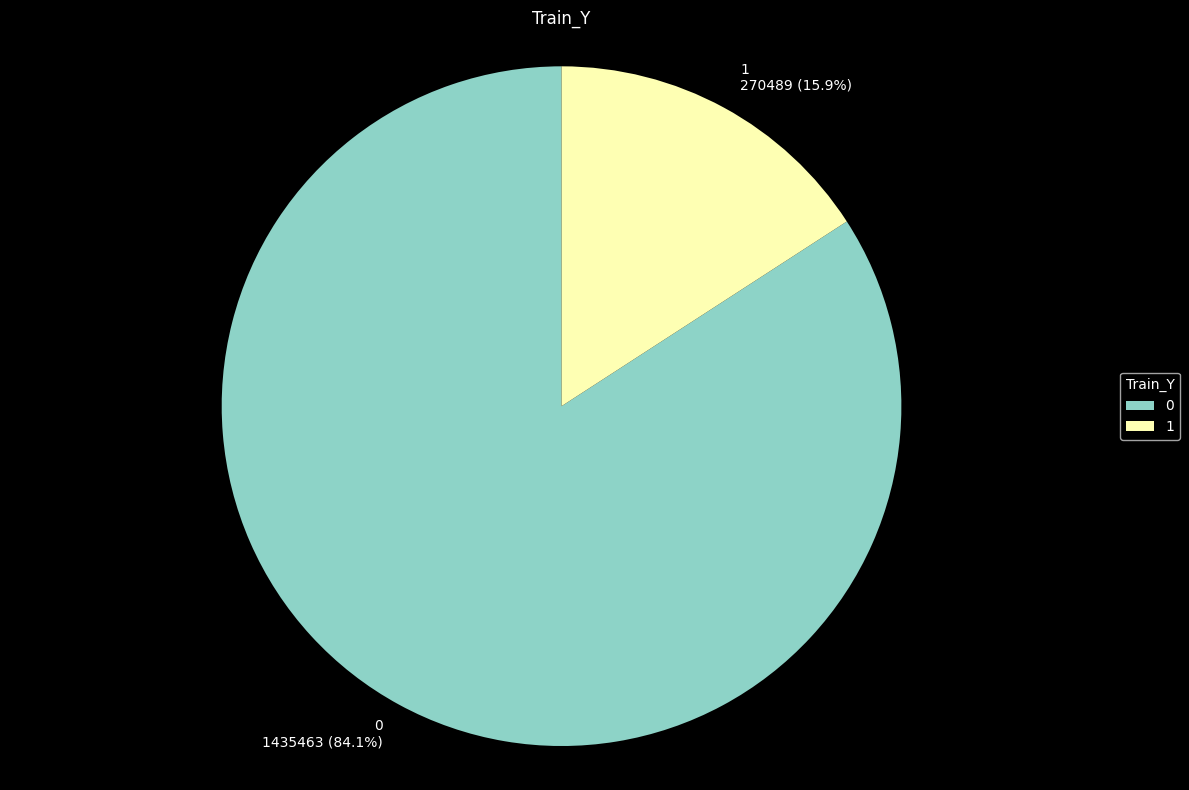

In [ ]:
# loan_status의 개수와 비율 계산
loan_status_counts = lending_club_train['Y'].value_counts()
loan_status_percentages = loan_status_counts / len(lending_club_train) * 100

# 레이블 생성 (카테고리명, 개수, 비율)
labels = [f'{index}\n{count} ({percentage:.1f}%)'
          for index, count, percentage in
          zip(loan_status_counts.index, loan_status_counts, loan_status_percentages)]

# 원그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(loan_status_counts, labels=labels, autopct='', startangle=90)
plt.title('Train_Y')
plt.axis('equal')

# 범례 추가
plt.legend(loan_status_counts.index, title="Train_Y", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

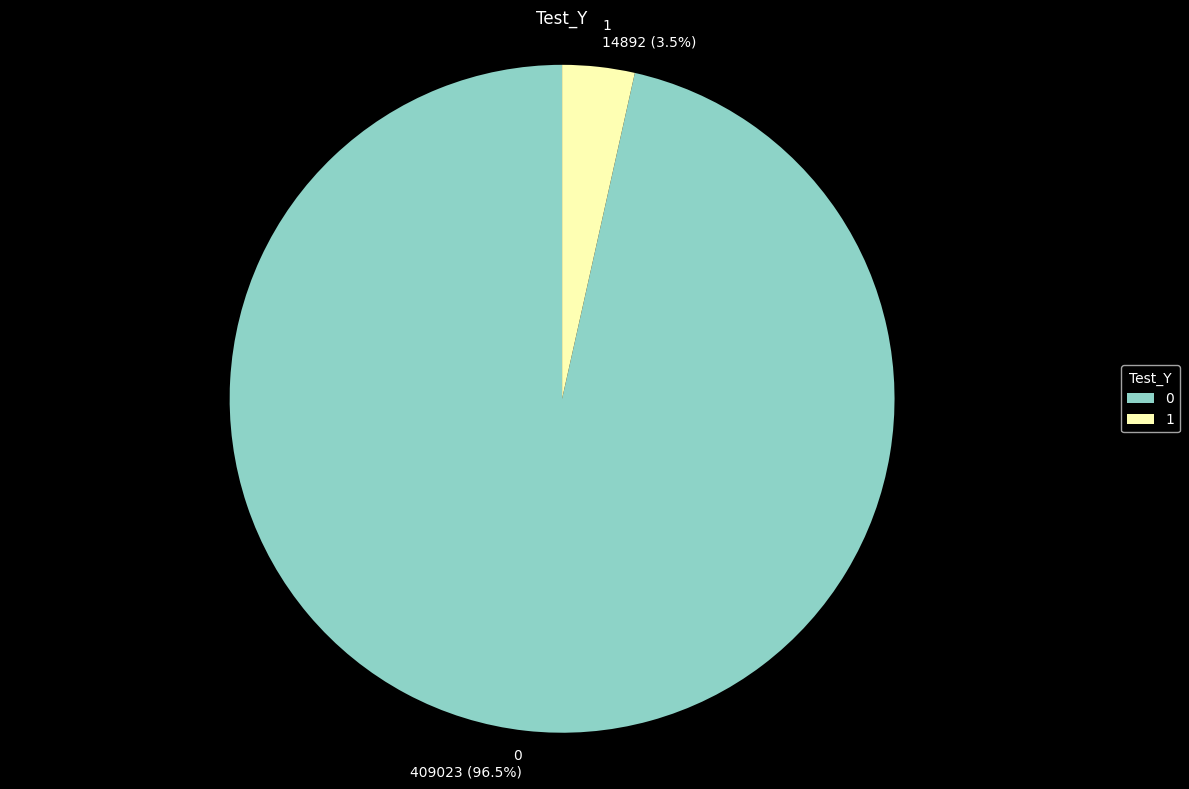

In [ ]:
# loan_status의 개수와 비율 계산
loan_status_counts = lending_club_test['Y'].value_counts()
loan_status_percentages = loan_status_counts / len(lending_club_test) * 100

# 레이블 생성 (카테고리명, 개수, 비율)
labels = [f'{index}\n{count} ({percentage:.1f}%)'
          for index, count, percentage in
          zip(loan_status_counts.index, loan_status_counts, loan_status_percentages)]

# 원그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(loan_status_counts, labels=labels, autopct='', startangle=90)
plt.title('Test_Y')
plt.axis('equal')

# 범례 추가
plt.legend(loan_status_counts.index, title="Test_Y", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

## object 데이터 처리
- 총 10개의 컬럼
- 데이터의 형태를 확인하며 처리

In [ ]:
lending_club_train.select_dtypes(include='object')

,id,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status,disbursement_method,region
0,68407277,36 months,C,C4,10+ years,MORTGAGE,Not Verified,debt_consolidation,PA,Aug-2003,w,Cash,NorthEast
1,68355089,36 months,C,C1,10+ years,MORTGAGE,Not Verified,small_business,SD,Dec-1999,w,Cash,MidWest
3,66310712,60 months,C,C5,10+ years,MORTGAGE,Source Verified,debt_consolidation,NJ,Sep-2008,w,Cash,NorthEast
4,68476807,60 months,F,F1,3 years,MORTGAGE,Source Verified,major_purchase,PA,Jun-1998,w,Cash,NorthEast
5,68426831,36 months,C,C3,4 years,RENT,Source Verified,debt_consolidation,GA,Oct-1987,w,Cash,SouthEast
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,60 months,C,C1,7 years,MORTGAGE,Source Verified,home_improvement,AL,Dec-1999,f,Cash,SouthEast
2260695,88977788,60 months,B,B3,10+ years,MORTGAGE,Not Verified,debt_consolidation,UT,Feb-1991,f,Cash,West
2260696,88985880,60 months,B,B3,9 years,MORTGAGE,Verified,debt_consolidation,CA,Feb-1995,f,Cash,West
2260697,88224441,60 months,C,C4,6 years,RENT,Not Verified,debt_consolidation,FL,Jul-1999,f,Cash,SouthEast


In [ ]:
# lending_club의 데이터 중 오브젝트로 이루어진 컬럼 항목을 리스트로 받아옴
obj_columns = lending_club_train.select_dtypes(include='object').columns.to_list()

obj_columns

['id',
 'term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'disbursement_method',
 'region']

In [ ]:
# term : 값이 2개
lending_club_train['term'].unique()

# int 타입으로 변환
lending_club_train['term'] = lending_club_train['term'].str.replace(' months', '')
lending_club_train['term'] = lending_club_train['term'].astype(int)

# test
lending_club_test['term'] = lending_club_test['term'].str.replace(' months', '')
lending_club_test['term'] = lending_club_test['term'].astype(int)

lending_club_train['term'].unique()

<ipython-input-32-19ef88dd33a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['term'] = lending_club_train['term'].str.replace(' months', '')
<ipython-input-32-19ef88dd33a7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['term'] = lending_club_train['term'].astype(int)
<ipython-input-32-19ef88dd33a7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

array([36, 60])

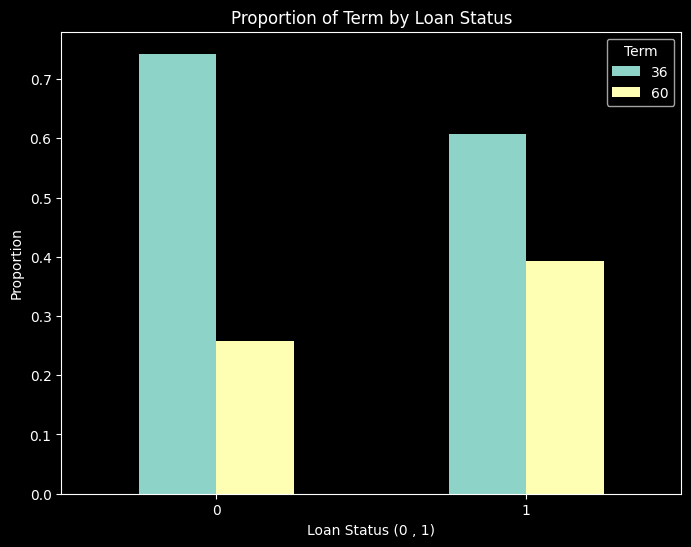

In [ ]:
# 'Y'와 'term' 조합에 따른 데이터 비율 계산
term_ratios = lending_club_train.groupby(['Y', 'term'])['term'].count().unstack()
term_ratios = term_ratios.apply(lambda x: x / x.sum(), axis=1)

# seaborn barplot 생성
term_ratios.plot(kind='bar', figsize=(8, 6))
plt.title('Proportion of Term by Loan Status')
plt.xlabel('Loan Status (0 , 1)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Term')
plt.show()

In [ ]:
# emp_length
print(lending_club_train['emp_length'].unique(), lending_club_train['emp_length'].nunique())

# emp_length 결측치 확인
lending_club_train['emp_length'].isnull().sum()

# 결측치를 0으로 채움
lending_club_train['emp_length'] = lending_club_train['emp_length'].fillna('0')

# 공백과 'years' , '+', '<' 문자 제거 후 인트 타입으로 변환
lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace('< 1 year', '0') # 1년 미만은 0
lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace(' ', '')
lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace('years', '')
lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace('year', '')
lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace('+', '')
lending_club_train['emp_length'] = lending_club_train['emp_length'].astype(int)

# test
lending_club_test['emp_length'] = lending_club_test['emp_length'].fillna('0')
lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace('< 1 year', '0') # 1년 미만은 0
lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace(' ', '')
lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace('years', '')
lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace('year', '')
lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace('+', '')

lending_club_test['emp_length'] = lending_club_test['emp_length'].astype(int)

# 확인
print(lending_club_train['emp_length'].unique(), lending_club_train['emp_length'].nunique(), lending_club_train['emp_length'].dtype)

['10+ years' '3 years' '4 years' '6 years' '1 year' '7 years' '8 years'
 '5 years' '2 years' '9 years' '< 1 year' nan] 11


<ipython-input-34-1e26bb77da50>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['emp_length'] = lending_club_train['emp_length'].fillna('0')
<ipython-input-34-1e26bb77da50>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['emp_length'] = lending_club_train['emp_length'].str.replace('< 1 year', '0') # 1년 미만은 0
<ipython-input-34-1e26bb77da50>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

[10  3  4  6  1  7  8  5  2  9  0] 11 int64


<ipython-input-34-1e26bb77da50>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['emp_length'] = lending_club_test['emp_length'].str.replace('+', '')
<ipython-input-34-1e26bb77da50>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['emp_length'] = lending_club_test['emp_length'].astype(int)


<Figure size 1200x800 with 0 Axes>

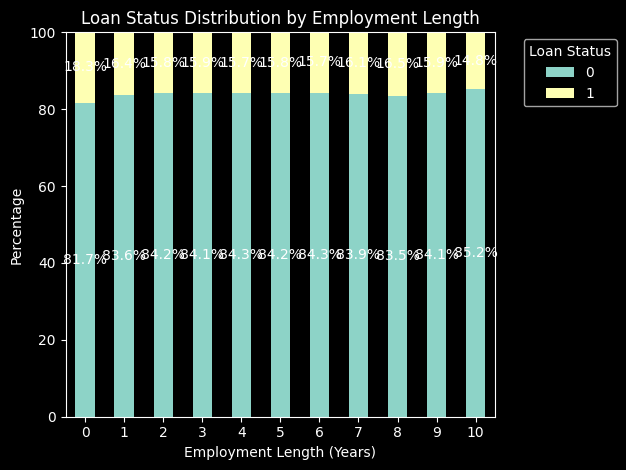

In [ ]:
# emp_length와 loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['emp_length'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status Distribution by Employment Length')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

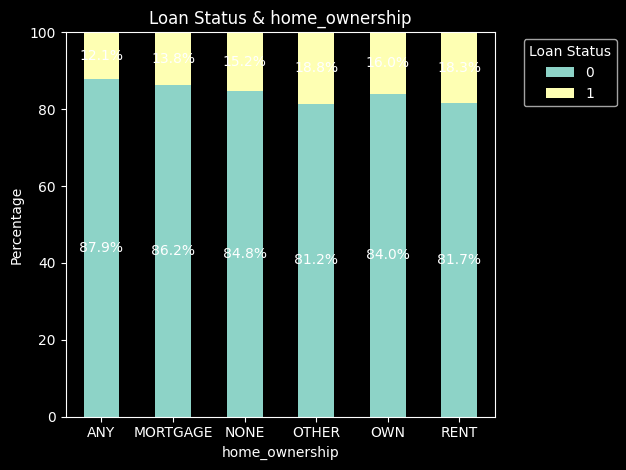

In [ ]:
# home_ownership와 loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['home_ownership'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status & home_ownership')
plt.xlabel('home_ownership')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

In [ ]:
# home_ownership
print(lending_club_train['home_ownership'].unique(), lending_club_train['home_ownership'].nunique())

# 'ANY' = 0, 'MORTGAGE' = 1, NONEE' = 2 , 'OWN' = 3 , 'RENT' = 4, 'OTHER' = 5
lending_club_train['home_ownership'] = lending_club_train['home_ownership'].map({'ANY': 0, 'MORTGAGE': 1, 'NONE': 2, 'OWN': 3, 'RENT': 4, 'OTHER':5})

# test
lending_club_test['home_ownership'] = lending_club_test['home_ownership'].map({'ANY': 0, 'MORTGAGE': 1, 'NONE': 2, 'OWN': 3, 'RENT': 4, 'OTHER':5})

# 확인
print(lending_club_train['home_ownership'].unique(), lending_club_train['home_ownership'].nunique(), lending_club_train['home_ownership'].dtype)

['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER'] 6
[1 4 3 0 2 5] 6 int64


<ipython-input-37-9dd76aa54b1e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['home_ownership'] = lending_club_train['home_ownership'].map({'ANY': 0, 'MORTGAGE': 1, 'NONE': 2, 'OWN': 3, 'RENT': 4, 'OTHER':5})
<ipython-input-37-9dd76aa54b1e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['home_ownership'] = lending_club_test['home_ownership'].map({'ANY': 0, 'MORTGAGE': 1, 'NONE': 2, 'OWN': 3, 'RENT': 4, 'OTHER':5})


<Figure size 1200x800 with 0 Axes>

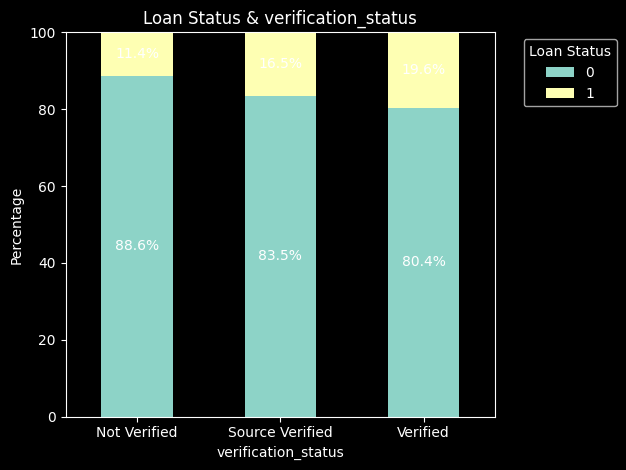

In [ ]:
# verification_status와 loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['verification_status'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status & verification_status')
plt.xlabel('verification_status')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

In [ ]:
# verification_status
print(lending_club_train['verification_status'].unique(), lending_club_train['verification_status'].nunique())

# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2
lending_club_train['verification_status'] = lending_club_train['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})

# test
lending_club_test['verification_status'] = lending_club_test['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})

# 확인
print(lending_club_train['verification_status'].unique(), lending_club_train['verification_status'].nunique(), lending_club_train['verification_status'].dtype)

['Not Verified' 'Source Verified' 'Verified'] 3
[0 1 2] 3 int64


<ipython-input-39-a3b27c803066>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['verification_status'] = lending_club_train['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})
<ipython-input-39-a3b27c803066>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['verification_status'] = lending_club_test['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})


In [ ]:
# purpose
print(lending_club_train['purpose'].unique(), lending_club_train['purpose'].nunique())

['debt_consolidation' 'small_business' 'major_purchase' 'credit_card'
 'other' 'home_improvement' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational'] 14


In [ ]:
# purpose
print(lending_club_train['purpose'].unique(), lending_club_train['purpose'].nunique())

# 'small_business' = 0, renewable_energyd' = 1, 'Verified' = 2
lending_club_train['purpose'] = lending_club_train['purpose'].map({'small_business': 0, 'renewable_energy': 1, 'moving': 2, 'house':3, 'educational':4, 'debt_consolidation':5, 'medical':6,'other':7,'vacation':8,
'major_purchase' : 9, 'home_improvement' : 10, 'credit_card' : 11, 'wedding' : 12, "car": 13})

# test
lending_club_test['purpose'] = lending_club_test['purpose'].map({'small_business': 0, 'renewable_energy': 1, 'moving': 2, 'house':3, 'educational':4, 'debt_consolidation':5, 'medical':6,'other':7,'vacation':8,
'major_purchase' : 9, 'home_improvement' : 10, 'credit_card' : 11, 'wedding' : 12, "car": 13})

# 확인
print(lending_club_train['purpose'].unique(), lending_club_train['purpose'].nunique(), lending_club_train['purpose'].dtype)

['debt_consolidation' 'small_business' 'major_purchase' 'credit_card'
 'other' 'home_improvement' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational'] 14
[ 5  0  9 11  7 10  3  8 13  6  2  1 12  4] 14 int64


<ipython-input-41-c93fcd21ff21>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['purpose'] = lending_club_train['purpose'].map({'small_business': 0, 'renewable_energy': 1, 'moving': 2, 'house':3, 'educational':4, 'debt_consolidation':5, 'medical':6,'other':7,'vacation':8,
<ipython-input-41-c93fcd21ff21>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['purpose'] = lending_club_test['purpose'].map({'small_business': 0, 'renewable_energy': 1, 'moving': 2, 'house':3, 'educ

In [ ]:
# earliest_cr_line 신용한도가 개설된 달
print(lending_club_train['earliest_cr_line'].unique(), lending_club_train['earliest_cr_line'].nunique())

# earliest_cr_line 날짜로 변환
lending_club_train['earliest_cr_line'] = pd.to_datetime(lending_club_train['earliest_cr_line'], format='%b-%Y')
lending_club_test['earliest_cr_line'] = pd.to_datetime(lending_club_test['earliest_cr_line'], format='%b-%Y')


# 파생변수

# 대출금 조달 일 - 신용한도 개설된 달
lending_club_train['cr_line_diff'] = pd.to_datetime(lending_club_train['issue_d'], format='%Y-%m-%d') - lending_club_train['earliest_cr_line']
lending_club_test['cr_line_diff'] = pd.to_datetime(lending_club_test['issue_d'], format='%Y-%m-%d') - lending_club_test['earliest_cr_line']

# 날짜를 숫자로 변환
lending_club_train['cr_line_diff'] = lending_club_train['cr_line_diff'].dt.days
lending_club_test['cr_line_diff'] = lending_club_test['cr_line_diff'].dt.days

# earliest_cr_line의 연도만 남김
lending_club_train['earliest_cr_line'] = lending_club_train['earliest_cr_line'].dt.year
lending_club_test['earliest_cr_line'] = lending_club_test['earliest_cr_line'].dt.year

# earliest_cr_line int로 변환
lending_club_train['earliest_cr_line'] = lending_club_train['earliest_cr_line'].astype(int)
lending_club_test['earliest_cr_line'] = lending_club_test['earliest_cr_line'].astype(int)

# 확인
print(lending_club_train['cr_line_diff'].unique(), lending_club_train['cr_line_diff'].nunique(), lending_club_train['cr_line_diff'].dtype)

['Aug-2003' 'Dec-1999' 'Sep-2008' 'Jun-1998' 'Oct-1987' 'Jun-1990'
 'Feb-1999' 'Apr-2002' 'Nov-1994' 'Apr-1995' 'Feb-1988' 'Jun-1996'
 'Jun-2005' 'May-1984' 'Dec-2001' 'Nov-1993' 'Sep-2001' 'Mar-2005'
 'May-2004' 'Jun-1991' 'May-2000' 'Oct-2011' 'May-1994' 'Jul-2011'
 'May-1991' 'May-2001' 'Jun-2002' 'Dec-1985' 'Apr-2007' 'Feb-2002'
 'Jun-2001' 'Jun-1997' 'Oct-1996' 'Jan-2005' 'Jul-2001' 'Aug-2004'
 'Jun-2007' 'Jul-2004' 'Apr-2001' 'Oct-2004' 'May-1992' 'Oct-1999'
 'Nov-2001' 'Oct-2005' 'Jan-2001' 'Sep-2004' 'Sep-1993' 'Nov-2005'
 'Feb-1989' 'Sep-2006' 'Oct-1982' 'Oct-2002' 'Feb-1990' 'Aug-1987'
 'Oct-1998' 'Aug-2001' 'Feb-2004' 'Aug-2009' 'Nov-1999' 'Jun-2006'
 'Jan-1999' 'Jun-2000' 'Jan-2007' 'Dec-1998' 'Aug-1997' 'Dec-1987'
 'Feb-1996' 'Apr-1990' 'Jun-2004' 'Jun-1995' 'Dec-2002' 'Aug-1986'
 'Nov-2002' 'Oct-2006' 'Sep-2000' 'Feb-2012' 'Apr-2005' 'Sep-1994'
 'Apr-1993' 'Sep-2007' 'Jan-1998' 'May-2008' 'Mar-2001' 'Apr-1994'
 'Apr-2003' 'Jan-2002' 'Jan-2011' 'Nov-2000' 'Sep-2002' 'May-2

<ipython-input-42-afd4c3676924>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['earliest_cr_line'] = pd.to_datetime(lending_club_train['earliest_cr_line'], format='%b-%Y')
<ipython-input-42-afd4c3676924>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['earliest_cr_line'] = pd.to_datetime(lending_club_test['earliest_cr_line'], format='%b-%Y')
<ipython-input-42-afd4c3676924>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


[ 4505  5844  2647 ... 20943 20728 21093] 2806 int64


<ipython-input-42-afd4c3676924>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['earliest_cr_line'] = lending_club_train['earliest_cr_line'].dt.year
<ipython-input-42-afd4c3676924>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['earliest_cr_line'] = lending_club_test['earliest_cr_line'].dt.year
<ipython-input-42-afd4c3676924>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

<Figure size 1200x800 with 0 Axes>

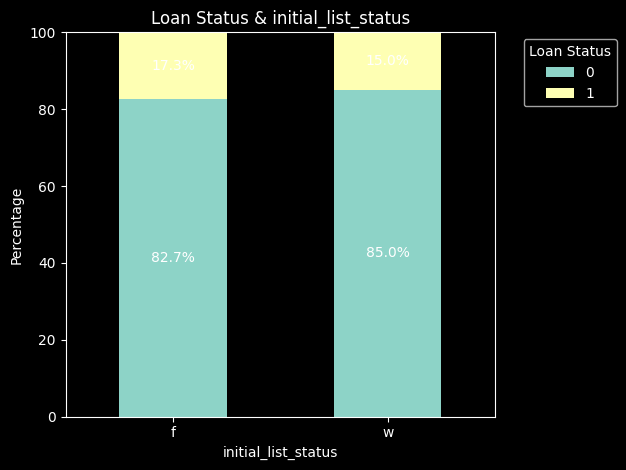

In [ ]:
# initial_list_status & loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['initial_list_status'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status & initial_list_status')
plt.xlabel('initial_list_status')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

In [ ]:
# initial_list_status 대출의 초기 상장 상태입니다. 가능한 값은 - W, F입니다.
print(lending_club_train['initial_list_status'].unique(), lending_club_train['initial_list_status'].nunique())

# label encoding
lending_club_train['initial_list_status'] = lending_club_train['initial_list_status'].map({'w': 0, 'f': 1})

# test
lending_club_test['initial_list_status'] = lending_club_test['initial_list_status'].map({'w': 0, 'f': 1})

# 확인
print(lending_club_train['initial_list_status'].unique(), lending_club_train['initial_list_status'].nunique(), lending_club_train['initial_list_status'].dtype)

['w' 'f'] 2
[0 1] 2 int64


<ipython-input-44-9c573550e034>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['initial_list_status'] = lending_club_train['initial_list_status'].map({'w': 0, 'f': 1})
<ipython-input-44-9c573550e034>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['initial_list_status'] = lending_club_test['initial_list_status'].map({'w': 0, 'f': 1})


<Figure size 1200x800 with 0 Axes>

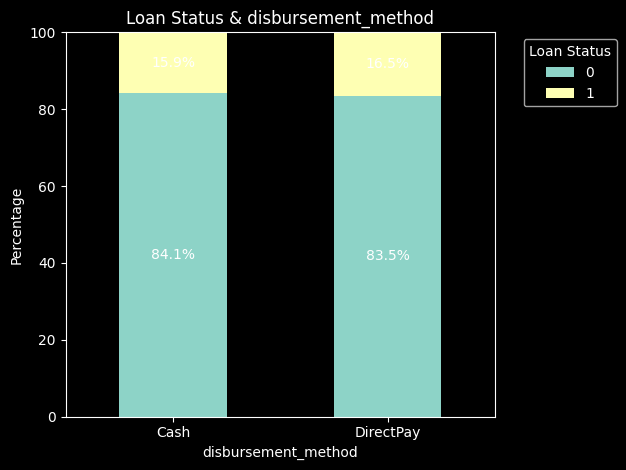

In [ ]:
# disbursement_method & loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['disbursement_method'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status & disbursement_method')
plt.xlabel('disbursement_method')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

In [ ]:
# 'disbursement_method' 차용인이 대출을 받는 방법입니다. 가능한 값은 CASH, DIRECT_PAY입니다.
print(lending_club_train['disbursement_method'].unique(), lending_club_train['disbursement_method'].nunique())

# label encoding
lending_club_train['disbursement_method'] = lending_club_train['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})

# test
lending_club_test['disbursement_method'] = lending_club_test['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})

# 확인
print(lending_club_train['disbursement_method'].unique(), lending_club_train['disbursement_method'].nunique(), lending_club_train['disbursement_method'].dtype)
print(lending_club_test['disbursement_method'].unique(), lending_club_test['disbursement_method'].nunique(), lending_club_test['disbursement_method'].dtype)

['Cash' 'DirectPay'] 2
[0 1] 2 int64
[0 1] 2 int64


<ipython-input-46-f70ba2d8b8ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_train['disbursement_method'] = lending_club_train['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})
<ipython-input-46-f70ba2d8b8ee>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_club_test['disbursement_method'] = lending_club_test['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})


<Figure size 1200x800 with 0 Axes>

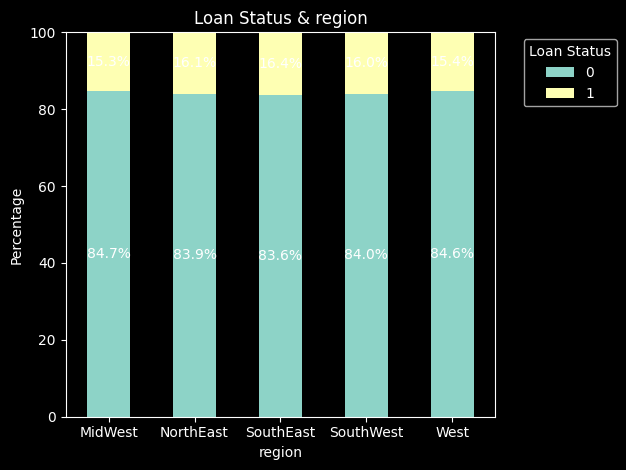

In [ ]:
# region & loan_status의 교차표 생성
cross_tab = pd.crosstab(lending_club_train['region'], lending_club_train['Y'], normalize='index')

# 백분율로 변환 (0-1 값을 0-100으로)
cross_tab = cross_tab * 100

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True)

plt.title('Loan Status & region')
plt.xlabel('region')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# y축을 0부터 100까지 표시
plt.ylim(0, 100)

# 각 막대 위에 퍼센트 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

In [ ]:
print(lending_club_train['region'].unique(), lending_club_train['region'].nunique())

# one hot encoding
lending_club_train = pd.get_dummies(lending_club_train, columns=['region'])
lending_club_test = pd.get_dummies(lending_club_test, columns=['region'])

['NorthEast' 'MidWest' 'SouthEast' 'SouthWest' 'West'] 5


## 결측치 처리
- 결측치 30% 이상의 컬럼 제거
- 중복되는 빈 데이터 제거
- 평균, 0 값 대체

In [ ]:
# 데이터프레임에서 결측치 개수 확인
missing_values = lending_club_train.isnull().sum()

# 결측치가 있는 컬럼 낮은 순으로 정렬
print(missing_values[missing_values > 0].sort_values())

inq_last_6mths                          1
tax_liens                              39
chargeoff_within_12_mths               56
pub_rec_bankruptcies                  697
revol_util                           1068
acc_open_past_24mths                47281
mort_acc                            47281
total_bc_limit                      47281
total_bal_ex_mort                   47281
num_sats                            55841
num_bc_sats                         55841
mths_since_recent_bc                63247
bc_open_to_buy                      64314
percent_bc_gt_75                    64750
bc_util                             65204
num_tl_90g_dpd_24m                  67527
tot_hi_cred_lim                     67527
num_accts_ever_120_pd               67527
num_actv_rev_tl                     67527
num_tl_op_past_12m                  67527
num_bc_tl                           67527
num_il_tl                           67527
num_rev_tl_bal_gt_0                 67527
num_tl_30dpd                      

In [ ]:
# 데이터프레임에서 결측치 개수 확인
missing_values = lending_club_test.isnull().sum()

# 결측치가 있는 컬럼 낮은 순으로 정렬
print(missing_values[missing_values > 0].sort_values())

pct_tl_nvr_dlq                         2
avg_cur_bal                           33
all_util                              87
revol_util                           438
mths_since_recent_bc                4587
bc_open_to_buy                      4894
percent_bc_gt_75                    4902
bc_util                             5071
num_tl_120dpd_2m                   12280
mths_since_rcnt_il                 15711
mo_sin_old_il_acct                 15711
mths_since_recent_inq              51337
il_util                            68372
mths_since_last_delinq            235250
mths_since_recent_revol_delinq    300458
mths_since_recent_bc_dlq          338880
mths_since_last_record            369554
dtype: int64


In [ ]:
dropna_cols = ["avg_cur_bal", "bc_util", "dti", "inq_last_6mths"]
lending_club_train.dropna(subset=dropna_cols, inplace=True)
lending_club_test.dropna(subset=dropna_cols, inplace=True)

In [ ]:
# 결측치 비율이 30퍼 이상인 컬럼
drop_cols = ['mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq','il_util','mths_since_rcnt_il','mths_since_last_delinq',
'all_util','total_bal_il', 'total_bal_il','open_rv_12m','open_rv_24m','open_il_12m','max_bal_bc','inq_fi','total_cu_tl','open_il_24m'
,'open_act_il','open_acc_6m','inq_last_12m']
lending_club_train.drop(columns=drop_cols, inplace=True)
lending_club_test.drop(columns=drop_cols, inplace=True)

In [ ]:
for col in ("mths_since_recent_inq", "mths_since_recent_bc",'pct_tl_nvr_dlq','percent_bc_gt_75','mo_sin_old_il_acct','num_tl_120dpd_2m'):
    lending_club_train[col].fillna(lending_club_train[col].mean(), inplace=True)
    lending_club_test[col].fillna(lending_club_test[col].mean(), inplace=True)

for col in ("num_rev_accts","mths_since_recent_bc"):
    lending_club_train[col].fillna(0, inplace=True)
    lending_club_test[col].fillna(0, inplace=True)

<ipython-input-53-f40612802520>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lending_club_train[col].fillna(lending_club_train[col].mean(), inplace=True)
<ipython-input-53-f40612802520>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [ ]:
# 중간 csv파일로 저장
lending_club_train.to_csv('/content/drive/MyDrive/Colab Notebooks/lending_club_train.csv', index=False)
lending_club_test.to_csv('/content/drive/MyDrive/Colab Notebooks/lending_club_test.csv', index=False)

In [ ]:
# train과 test 불러옴
lending_club_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending_club_train.csv')
lending_club_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending_club_test.csv')

In [ ]:
lending_club_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620785 entries, 0 to 1620784
Data columns (total 76 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1620785 non-null  int64  
 1   loan_amnt                   1620785 non-null  float64
 2   funded_amnt                 1620785 non-null  float64
 3   funded_amnt_inv             1620785 non-null  float64
 4   term                        1620785 non-null  int64  
 5   int_rate                    1620785 non-null  float64
 6   installment                 1620785 non-null  float64
 7   grade                       1620785 non-null  object 
 8   sub_grade                   1620785 non-null  object 
 9   emp_length                  1620785 non-null  int64  
 10  home_ownership              1620785 non-null  int64  
 11  annual_inc                  1620785 non-null  float64
 12  verification_status         1620785 non-null  int64  
 1

<Axes: >

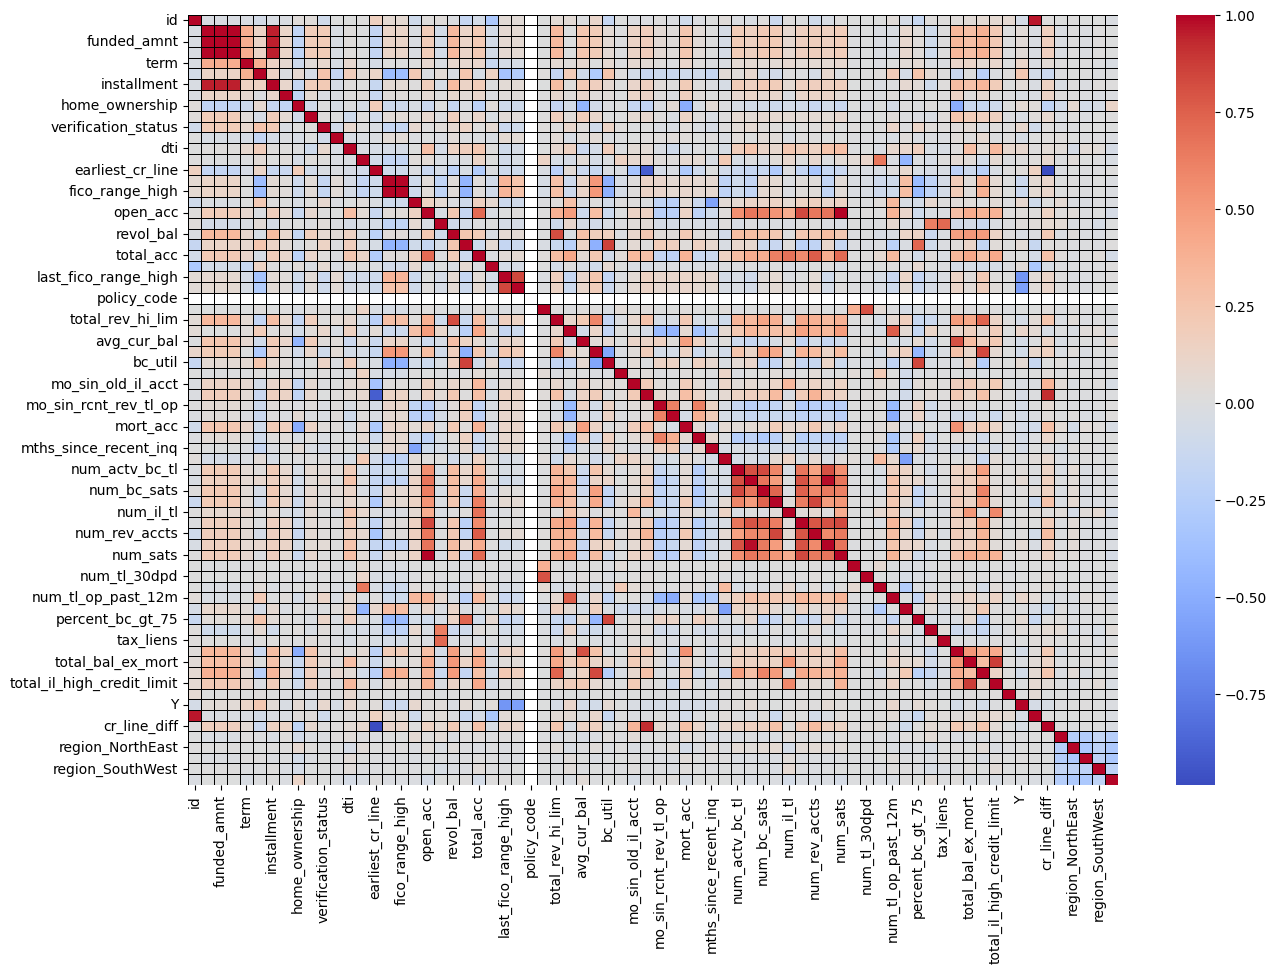

In [ ]:
# object, datetime 변수 제외
corr_df = lending_club_train.select_dtypes(exclude=['object', 'datetime64[ns]'])
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df.corr(), annot=False, linecolor='black', linewidths=0.5, cmap='coolwarm')

## 데이터 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler, QuantileTransformer

# 오브젝트, Y 제외
columns_to_scale = [col for col in lending_club_train.columns if col not in ['id', 'Y','issue_d','grade','sub_grade','addr_state','int_rate','fico_range_low','fico_range_high','last_fico_range_low','last_fico_range_high']]

scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = QuantileTransformer()

lending_club_train[columns_to_scale] = scaler.fit_transform(lending_club_train[columns_to_scale])
lending_club_test[columns_to_scale] = scaler.transform(lending_club_test[columns_to_scale])

# 통계 검증

## 정규성

In [ ]:
# 정규성을 만족하지 않는 컬럼을 담을 리스트
non_normal_columns = []

# 각 컬럼에 대해 Shapiro-Wilk 검정 수행
for column in lending_club_train.columns:
    if lending_club_train[column].dtype in ['float64', 'int64']:  # 수치형 데이터에 대해서만 수행
        stat, p_value = stats.shapiro(lending_club_train[column].dropna())  # NaN 값은 제외
        if p_value < 0.01:  # p-value가 0.01보다 작으면 정규성을 만족하지 않음
            non_normal_columns.append(column)

print("정규성을 만족하지 않는 컬럼:")
print(non_normal_columns)
print(len(non_normal_columns))

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1620785.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


정규성을 만족하지 않는 컬럼:
['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_b

## t-test

In [ ]:
group_0 = lending_club_train[lending_club_train['Y'] == 0]
group_1 = lending_club_train[lending_club_train['Y'] == 1]

# t-검정을 수행하여 p-value가 0.01보다 작은 열을 담을 리스트
ttest_pass_columns = []

# 각 컬럼에 대해 t-검정 수행
for column in lending_club_train.columns:
    if lending_club_train[column].dtype in ['float64', 'int64'] and column != 'Y':  # 수치형 데이터에 대해서만 수행
        stat, p_value = stats.ttest_ind(group_0[column].dropna(), group_1[column].dropna(), equal_var=False)  # 등분산 가정하지 않음
        if p_value < 0.01:  # p-value가 0.01보다 작으면 두 그룹 간의 평균 차이가 있음
            ttest_pass_columns.append(column)

print("대립가설 채택 피처 (p-value < 0.01):")
print(ttest_pass_columns)
print(len(ttest_pass_columns))

대립가설 채택 피처 (p-value < 0.01):
['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cr

# 모델링

## Train, Val split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(lending_club_train[columns_to_scale], lending_club_train['Y'], test_size=0.2, random_state=42, stratify=lending_club_train['Y'])
X_test = lending_club_test[columns_to_scale]
y_test = lending_club_test['Y']

## 성능평가

- 성능평가지표

    1) 대출 신청자 : FP의 경우 -> 잠재 고객을 감소

    2) 투자자 : FN의 경우 -> 손실 발생 -> 투자자 감소

    3) LendingClub : 수요와 공급을 적절히 조절할 수 있는 지표가 필요할 것으로 예상

- 주요 지표 선정 :  AUROC

-> 불균형 데이터에 적절한 성능지표, 모든 임계값의 성능을 비교할 수 있다.

In [ ]:
# 성능확인 코드
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, fbeta_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    pr_score = average_precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    f2 = fbeta_score(y_test, pred, beta=2)

    # G-mean 계산
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    fpr = fp / (fp + tn)
    gmean = np.sqrt(tpr * tnr)

    # ar
    ar = 2 * accuracy - 1
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f},F1 스코어:{3:.4f}, f2 :{4:.4f}'.format(accuracy, precision, recall, f1, f2))
    print('ROC 스코어: {0:.4f}, PR 스코어 : {1:.4f}, G-mean : {2:.4f}, AR : {3:.4f}'.format(roc_score, pr_score, gmean, ar))

# 임계값에 따른 오차행렬및 스코어 -------->#임계값 최적 : 재현율기준(0.1)/f1기준(0.3)
from sklearn.preprocessing import Binarizer
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        # ROC 커브 계산
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba_c1)
        roc_auc = auc(fpr, tpr)
        # k-s
        ks_statistic = max(tpr - fpr)
        print("임곗값:", custom_threshold)
        print("ROC_AUC:", roc_auc)
        print("K-S:", ks_statistic)
        get_clf_eval(y_test, custom_predict)
        print("---------------------------------------------------------")

from sklearn.metrics import roc_curve, auc
def roc(model,name) :
    # 테스트 데이터에 대한 예측 확률 계산
    pred = model.predict_proba(X_test)[:, 1]

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC 커브에 AUC 면적에 색을 입히는 코드 수정
    plt.figure(figsize=(10, 6))

    # ROC 커브 시각화 및 AUC 면적 색칠
    plt.fill_between(fpr, tpr, color='palegoldenrod', alpha=0.4, label=f'Area under curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr, tpr, color='peru', lw=2)

    # 기본 설정
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}')
    plt.legend(loc="lower right")
    return plt.show()

In [ ]:
from lightgbm import LGBMClassifier

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'max_depth': [3, 5, 7],
# }

# 모델 생성
best_lgbm_model = LGBMClassifier(random_state=17,
                    # n_estimators=200, #트리의 최대 개수 (n_estimators): 100
                    # learning_rate=0.01,  #학습률 (learning_rate): 0.1
                    # num_leaves= 12,  #리프 노드의 최대 개수 (num_leaves): 31
                    # max_depth=5,    #트리의 최대 깊이 (max_depth): -1 (제한 없음)
                    # bagging_fraction=0.5,
                    # feature_fraction=0.5,
                    # lambda_l1=0.1,
                    # lambda_l2=0.1,
                    # verbose_eval = -1
                    )

# # GridSearchCV 설정
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc_score', n_jobs=-1, verbose=2)

# # 학습
# grid_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best AUC score: {grid_search.best_score_}")

# # 최적의 모델로 예측
# best_lgbm_model = grid_search.best_estimator_

best_lgbm_model.fit(X_train, y_train)
y_pred = best_lgbm_model.predict(X_val)
y_pred_proba = best_lgbm_model.predict_proba(X_val)[:, 1]

get_clf_eval(y_val, y_pred)
get_eval_by_threshold(y_val , y_pred_proba.reshape(-1,1), thresholds)

[LightGBM] [Info] Number of positive: 205809, number of negative: 1090819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.509040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6724
[LightGBM] [Info] Number of data points in the train set: 1296628, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158726 -> initscore=-1.667736
[LightGBM] [Info] Start training from score -1.667736
오차행렬
[[271764    941]
 [ 50296   1156]]
정확도: 0.8419, 정밀도 : 0.5513, 재현율:0.0225,F1 스코어:0.0432, f2 :0.0278
ROC 스코어: 0.5095, PR 스코어 : 0.1675, G-mean : 0.1496, AR : 0.6839
임곗값: 0.1
ROC_AUC: 0.7137077112379426
K-S: 0.31018527076287983
오차행렬
[[101938 170767]
 [  6393  45059]]
정확도: 0.4535, 정밀도 : 0.2088, 재현율:0.8757,F1 스코어:0.3372, f2 :0.5343
ROC 스코어: 0.6248, PR 스코어 : 0.2026, G-mean : 0.5722, AR : -0.0931
----------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[272705      0]
 [ 51452      0]]
정확도: 0.8413, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.1587, G-mean : 0.0000, AR : 0.6825
---------------------------------------------------------
임곗값: 0.9
ROC_AUC: 0.7137077112379426
K-S: 0.31018527076287983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[272705      0]
 [ 51452      0]]
정확도: 0.8413, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.1587, G-mean : 0.0000, AR : 0.6825
---------------------------------------------------------


In [ ]:
y_pred = best_lgbm_model.predict(X_test)
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred)
get_eval_by_threshold(y_test , y_pred_proba.reshape(-1,1), thresholds)

오차행렬
[[404175     32]
 [ 14631      6]]
정확도: 0.9650, 정밀도 : 0.1579, 재현율:0.0004,F1 스코어:0.0008, f2 :0.0005
ROC 스코어: 0.5002, PR 스코어 : 0.0350, G-mean : 0.0202, AR : 0.9300
임곗값: 0.1
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829
오차행렬
[[235304 168903]
 [  4089  10548]]
정확도: 0.5870, 정밀도 : 0.0588, 재현율:0.7206,F1 스코어:0.1087, f2 :0.2216
ROC 스코어: 0.6514, PR 스코어 : 0.0521, G-mean : 0.6477, AR : 0.1740
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829
오차행렬
[[372392  31815]
 [ 11022   3615]]
정확도: 0.8977, 정밀도 : 0.1020, 재현율:0.2470,F1 스코어:0.1444, f2 :0.1923
ROC 스코어: 0.5841, PR 스코어 : 0.0515, G-mean : 0.4770, AR : 0.7955
---------------------------------------------------------
임곗값: 0.3
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829
오차행렬
[[398831   5376]
 [ 13702    935]]
정확도: 0.9545, 정밀도 : 0.1482, 재현율:0.0639,F1 스코어:0.0893, f2 :0.0721
ROC 스코어: 0.5253, PR 스코어 : 0.0422, G-mean : 0.2511, AR : 0.9089
---------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[404207      0]
 [ 14637      0]]
정확도: 0.9651, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.0349, G-mean : 0.0000, AR : 0.9301
---------------------------------------------------------
임곗값: 0.7
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[404207      0]
 [ 14637      0]]
정확도: 0.9651, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.0349, G-mean : 0.0000, AR : 0.9301
---------------------------------------------------------
임곗값: 0.8
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[404207      0]
 [ 14637      0]]
정확도: 0.9651, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.0349, G-mean : 0.0000, AR : 0.9301
---------------------------------------------------------
임곗값: 0.9
ROC_AUC: 0.7102577083726458
K-S: 0.3082359271941829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차행렬
[[404207      0]
 [ 14637      0]]
정확도: 0.9651, 정밀도 : 0.0000, 재현율:0.0000,F1 스코어:0.0000, f2 :0.0000
ROC 스코어: 0.5000, PR 스코어 : 0.0349, G-mean : 0.0000, AR : 0.9301
---------------------------------------------------------


# 등급화

## 예측값 시각화

In [ ]:
# 예측값들을 lending_club_test에 추가
lending_club_test['predicted_default'] = y_pred
lending_club_test['default_probability'] = y_pred_proba

# 등급별 예측 결과 확인을 위한 데이터 출력
comparison_df = lending_club_test[['Y', 'predicted_default', 'default_probability', 'grade', 'sub_grade','int_rate','last_fico_range_low','last_fico_range_high']]

# 컬럼명을 좀 더 명확하게 변경
comparison_df = comparison_df.rename(columns={
    'Y': 'actual_default',
    'grade': 'actual_grade',
    'sub_grade': 'actual_subgrade'
})

print("\n처음 5개 행 확인:")
print(comparison_df.head())

print("\n기본 통계:")
print(comparison_df.describe())

print("\n실제 등급별 예측 확률 평균:")
print(comparison_df.groupby('actual_grade')['default_probability'].mean().round(3))


처음 5개 행 확인:
   actual_default  predicted_default  default_probability actual_grade  \
0               0                  0             0.157645            D   
1               0                  0             0.097418            B   
2               0                  0             0.218853            D   
3               0                  0             0.024054            A   
4               0                  0             0.184676            D   

  actual_subgrade  int_rate  last_fico_range_low  last_fico_range_high  
0              D4     20.39                605.0                 609.0  
1              B2      9.92                690.0                 694.0  
2              D5     21.85                665.0                 669.0  
3              A4      7.34                760.0                 764.0  
4              D4     20.39                630.0                 634.0  

기본 통계:
       actual_default  predicted_default  default_probability       int_rate  \
count   418844.0

## 실제 부도율과 비교
- 1.실제 등급별 부도율
- 2.실제 서브등급별 부도율
- 3.예측확률과 실제부도율
- 4.등급별 ROC스코어


등급별 성능 지표:
  Grade   Count  Accuracy  Precision  Recall     F1  ROC_AUC  \
0     A  118842     0.991      0.000   0.000  0.000    0.652   
1     B  120094     0.974      0.000   0.000  0.000    0.626   
2     C  106106     0.956      0.000   0.000  0.000    0.622   
3     D   56355     0.929      0.188   0.001  0.002    0.607   
4     E   14858     0.907      0.250   0.002  0.004    0.614   
5     F    2180     0.865      0.000   0.000  0.000    0.568   
6     G     409     0.848      0.000   0.000  0.000    0.588   

   Avg_Default_Prob  Actual_Default_Rate  
0             0.060                0.009  
1             0.093                0.026  
2             0.128                0.044  
3             0.158                0.070  
4             0.178                0.092  
5             0.212                0.133  
6             0.190                0.152  

서브등급별 성능 지표:
   Sub_Grade  Count  Avg_Default_Prob  Actual_Default_Rate
0         A1  25741             0.050                0.005

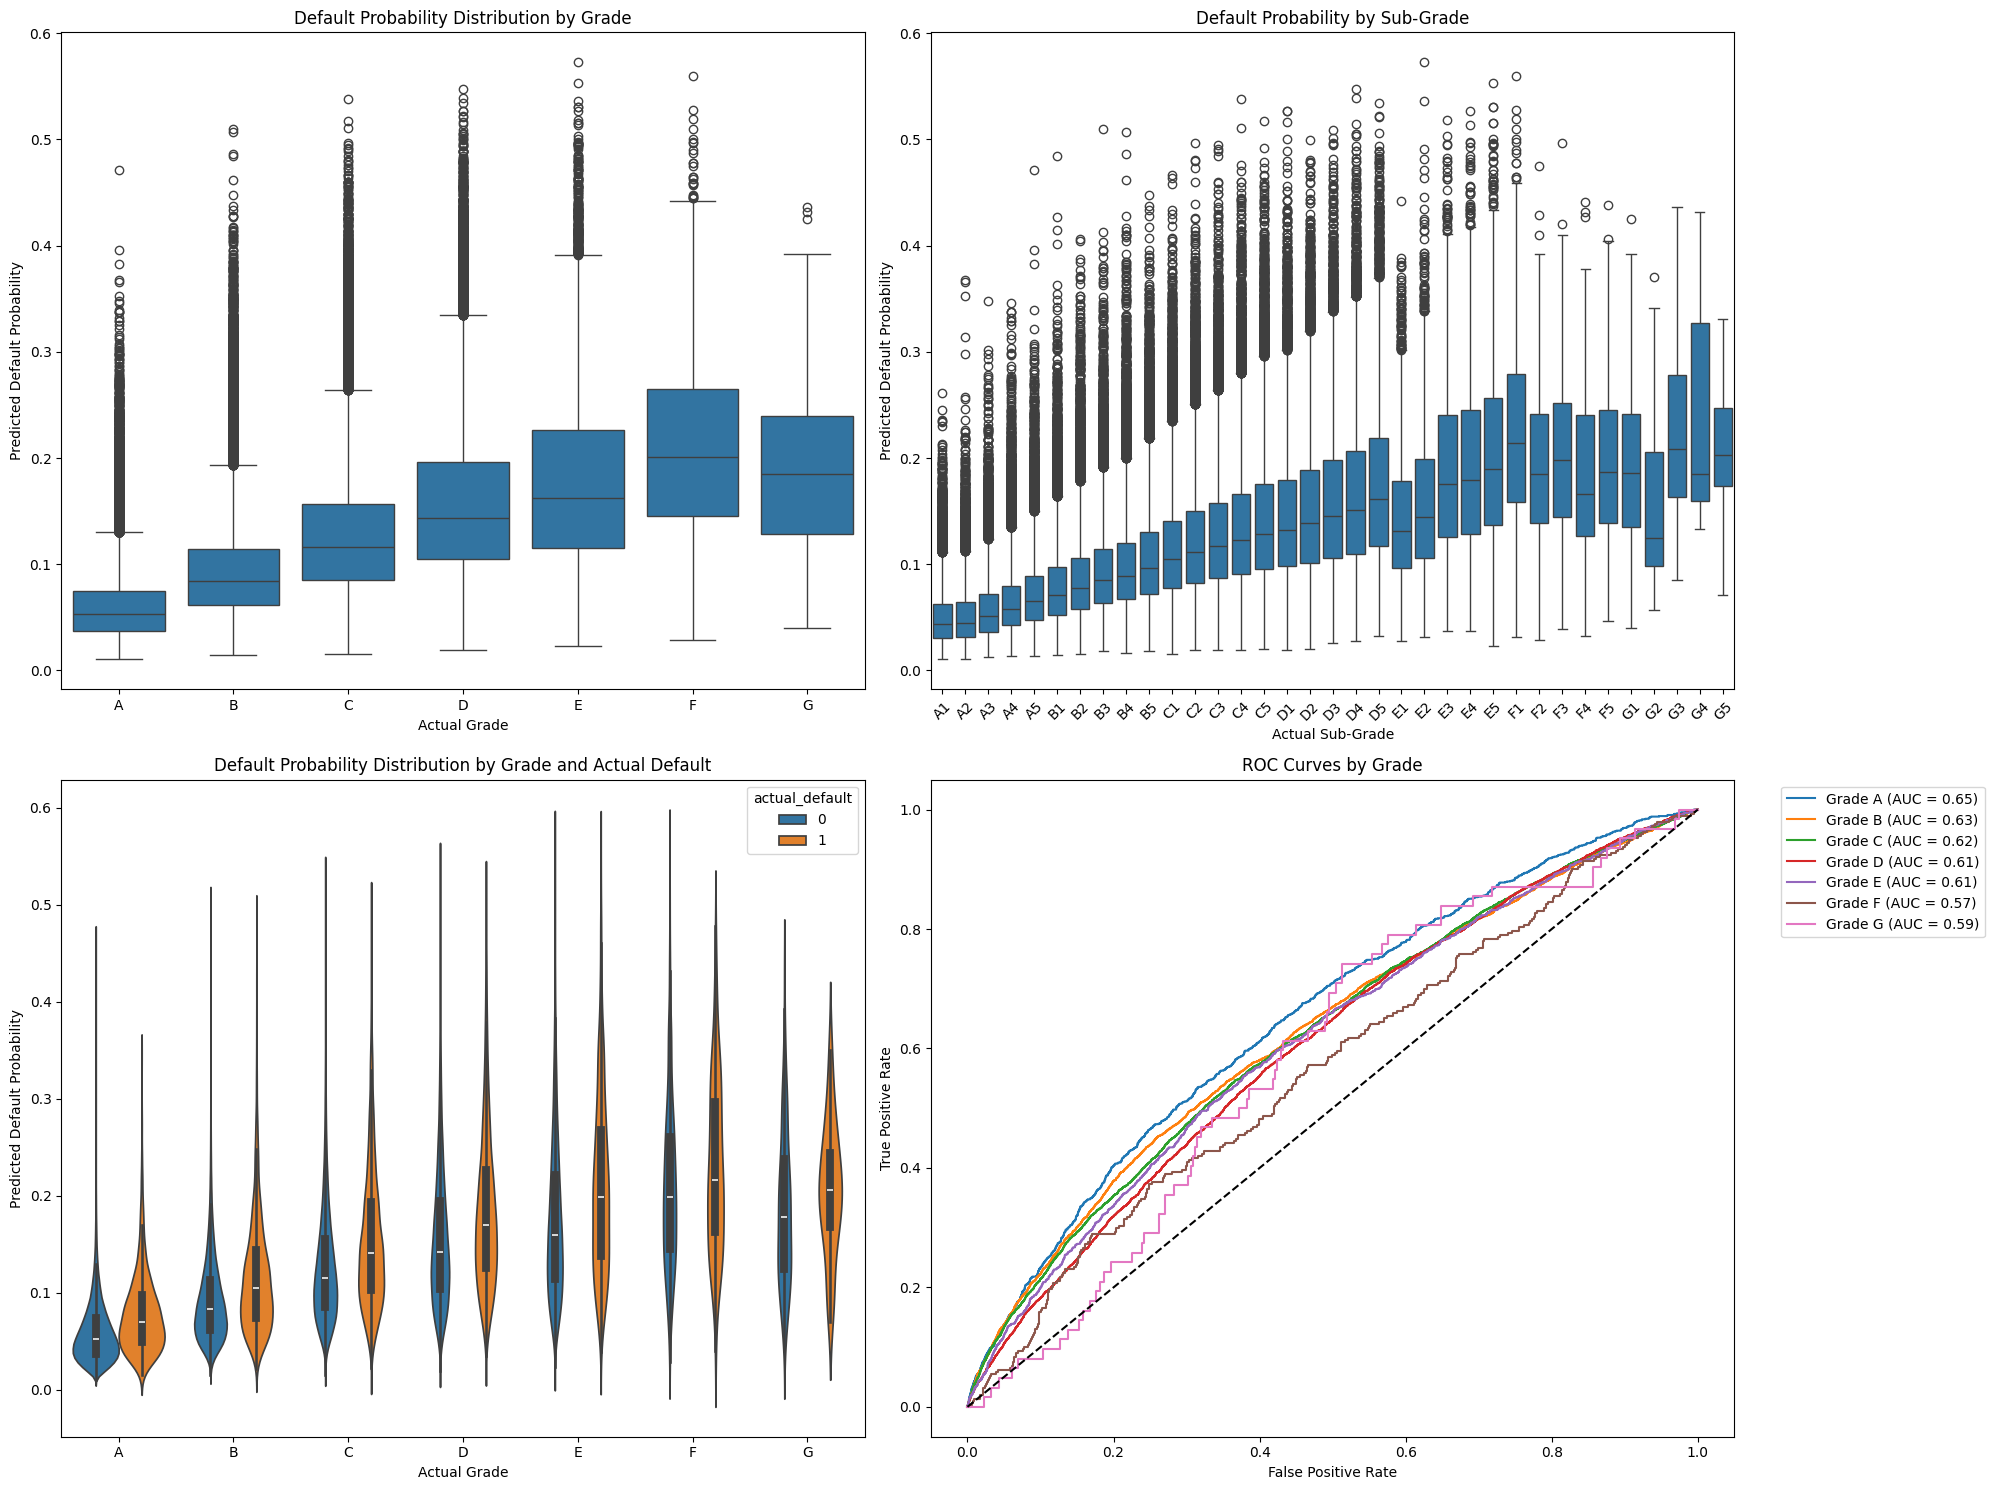

In [ ]:
def create_grade_order():
    """등급 순서 생성"""
    grades = []
    for main_grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for sub_grade in range(1, 6):
            grades.append(f'{main_grade}{sub_grade}')
    return grades

def visualize_prediction_analysis(df, figsize=(20, 15)):
    """예측 결과와 실제 등급의 관계를 다양한 방식으로 시각화"""

    # 등급 순서 설정
    grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrade_order = create_grade_order()

    fig = plt.figure(figsize=figsize)

    # 1. 등급별 디폴트 확률 분포 (boxplot)
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df, x='actual_grade', y='default_probability', order=grade_order)
    plt.title('Default Probability Distribution by Grade', fontsize=12)
    plt.xlabel('Actual Grade')
    plt.ylabel('Predicted Default Probability')

    # 2. 서브등급별 디폴트 확률 추세
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='actual_subgrade', y='default_probability', order=subgrade_order)
    plt.title('Default Probability by Sub-Grade', fontsize=12)
    plt.xlabel('Actual Sub-Grade')
    plt.ylabel('Predicted Default Probability')
    plt.xticks(rotation=45)

    # 3. 실제 디폴트와 예측 확률의 관계 (violin plot)
    plt.subplot(2, 2, 3)
    sns.violinplot(data=df, x='actual_grade', y='default_probability',
                  hue='actual_default', order=grade_order)
    plt.title('Default Probability Distribution by Grade and Actual Default', fontsize=12)
    plt.xlabel('Actual Grade')
    plt.ylabel('Predicted Default Probability')

    # 4. ROC curve by grade
    plt.subplot(2, 2, 4)
    for grade in grade_order:
        grade_mask = df['actual_grade'] == grade
        grade_data = df[grade_mask]
        if len(grade_data) > 0:  # 데이터가 있는 경우에만 플롯
            fpr, tpr, _ = roc_curve(grade_data['actual_default'], grade_data['default_probability'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Grade {grade} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Grade', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    return fig


def analyze_grade_performance(df):
    """등급별 성능 지표 계산"""

    # 등급 순서 설정
    grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrade_order = create_grade_order()

    grade_metrics = []

    # 메인 등급별 성능
    for grade in grade_order:
        grade_data = df[df['actual_grade'] == grade]

        if len(grade_data) > 0:
            accuracy = (grade_data['predicted_default'] == grade_data['actual_default']).mean()
            precision = precision_score(grade_data['actual_default'],
                                     grade_data['predicted_default'], zero_division=0)
            recall = recall_score(grade_data['actual_default'],
                                grade_data['predicted_default'], zero_division=0)
            f1 = f1_score(grade_data['actual_default'],
                         grade_data['predicted_default'], zero_division=0)
            roc_auc = roc_auc_score(grade_data['actual_default'],
                                   grade_data['default_probability'])

            grade_metrics.append({
                'Grade': grade,
                'Count': len(grade_data),
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'ROC_AUC': roc_auc,
                'Avg_Default_Prob': grade_data['default_probability'].mean(),
                'Actual_Default_Rate': grade_data['actual_default'].mean()
            })

    metrics_df = pd.DataFrame(grade_metrics)

    # 서브등급별 성능
    subgrade_metrics = []
    for subgrade in subgrade_order:
        subgrade_data = df[df['actual_subgrade'] == subgrade]

        if len(subgrade_data) > 0:
            subgrade_metrics.append({
                'Sub_Grade': subgrade,
                'Count': len(subgrade_data),
                'Avg_Default_Prob': subgrade_data['default_probability'].mean(),
                'Actual_Default_Rate': subgrade_data['actual_default'].mean()
            })

    subgrade_metrics_df = pd.DataFrame(subgrade_metrics)

    return metrics_df, subgrade_metrics_df

# 시각화 및 분석 실행
main_viz = visualize_prediction_analysis(comparison_df)
grade_performance, subgrade_performance = analyze_grade_performance(comparison_df)

# 성능 지표 출력
print("\n등급별 성능 지표:")
print(grade_performance.round(3))

print("\n서브등급별 성능 지표:")
print(subgrade_performance.round(3))

# 시각화 표시
plt.show()  # 메인 시각화
plt.show()  # 추가 시각화

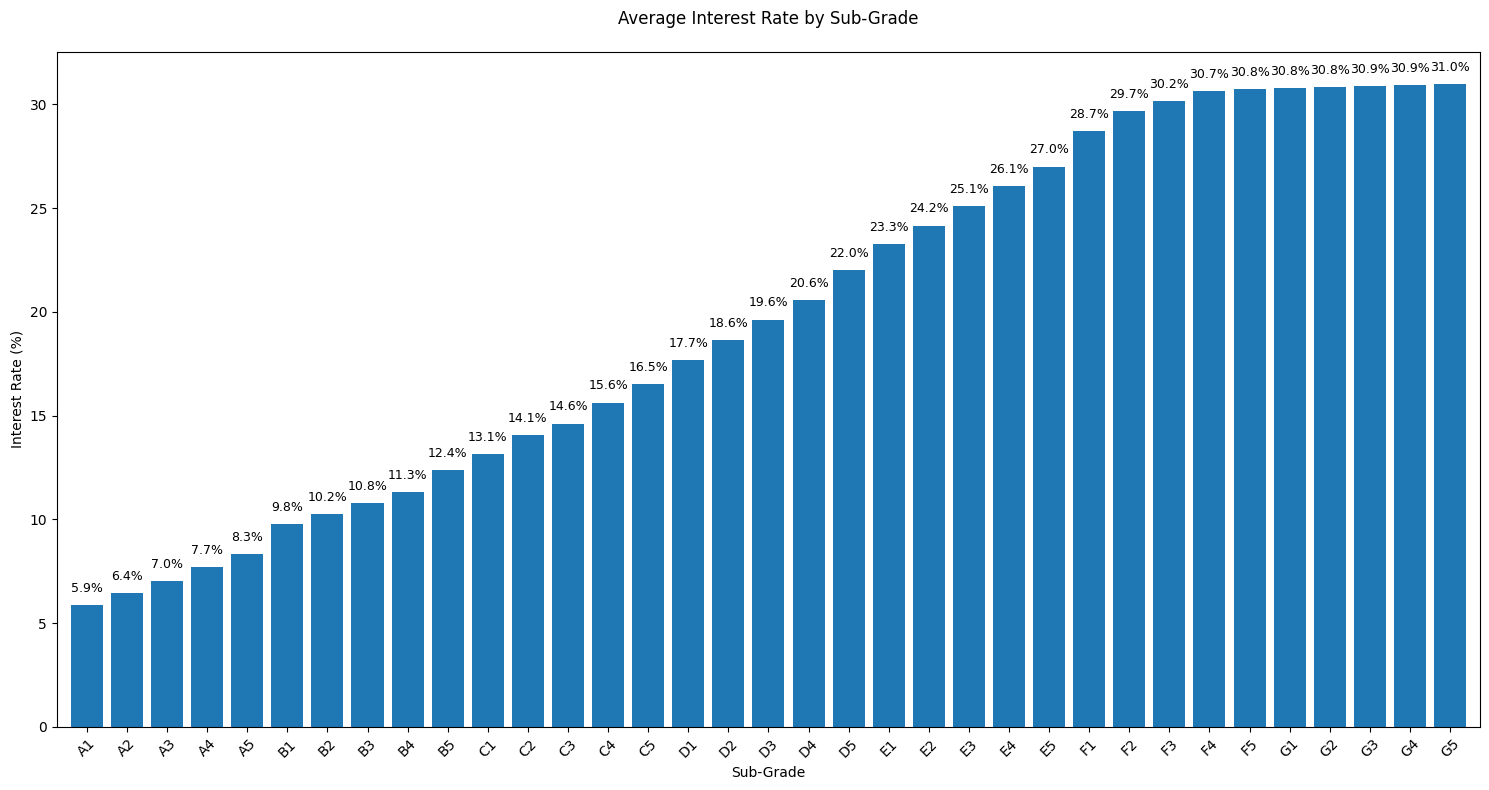


세부등급별 평균 이자율:
actual_subgrade
A1     5.85
A2     6.44
A3     7.02
A4     7.70
A5     8.31
B1     9.79
B2    10.25
B3    10.79
B4    11.31
B5    12.39
C1    13.14
C2    14.07
C3    14.62
C4    15.63
C5    16.51
D1    17.68
D2    18.65
D3    19.62
D4    20.58
D5    22.02
E1    23.26
E2    24.16
E3    25.09
E4    26.06
E5    27.00
F1    28.70
F2    29.69
F3    30.17
F4    30.65
F5    30.75
G1    30.79
G2    30.84
G3    30.89
G4    30.94
G5    30.99
Name: int_rate, dtype: float64


In [ ]:
# 세부등급별 평균 이자율 시각화
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(avg_int_rate)), avg_int_rate)
plt.title('Average Interest Rate by Sub-Grade', fontsize=12, pad=20)
plt.xlabel('Sub-Grade')
plt.ylabel('Interest Rate (%)')

# x축 레이블 설정
plt.xticks(range(len(subgrade_order)), subgrade_order, rotation=45)

# 값 표시 - 막대 위에 조금 더 간격을 두고 표시
for i, v in enumerate(avg_int_rate):
    plt.text(i, v + 0.5, f'{v:.1f}%',
             ha='center',
             va='bottom',
             fontsize=9)  # 폰트 크기 조정

# 여백 조정
plt.margins(x=0.01)  # x축 여백 줄이기
plt.tight_layout()

plt.show()

# 세부등급별 평균 이자율 출력
print("\n세부등급별 평균 이자율:")
print(avg_int_rate.round(2))

## 기존 등급과 부도율


세부등급별 부도율:
                 total_count  default_count  default_rate_pct
actual_subgrade                                              
A1                     25741            126              0.49
A2                     19909            143              0.72
A3                     22221            206              0.93
A4                     27457            311              1.13
A5                     23514            319              1.36
B1                     23500            460              1.96
B2                     24814            536              2.16
B3                     20202            515              2.55
B4                     27108            736              2.72
B5                     24470            883              3.61
C1                     23773            846              3.56
C2                     21051            869              4.13
C3                     22059            925              4.19
C4                     20252           1036              5

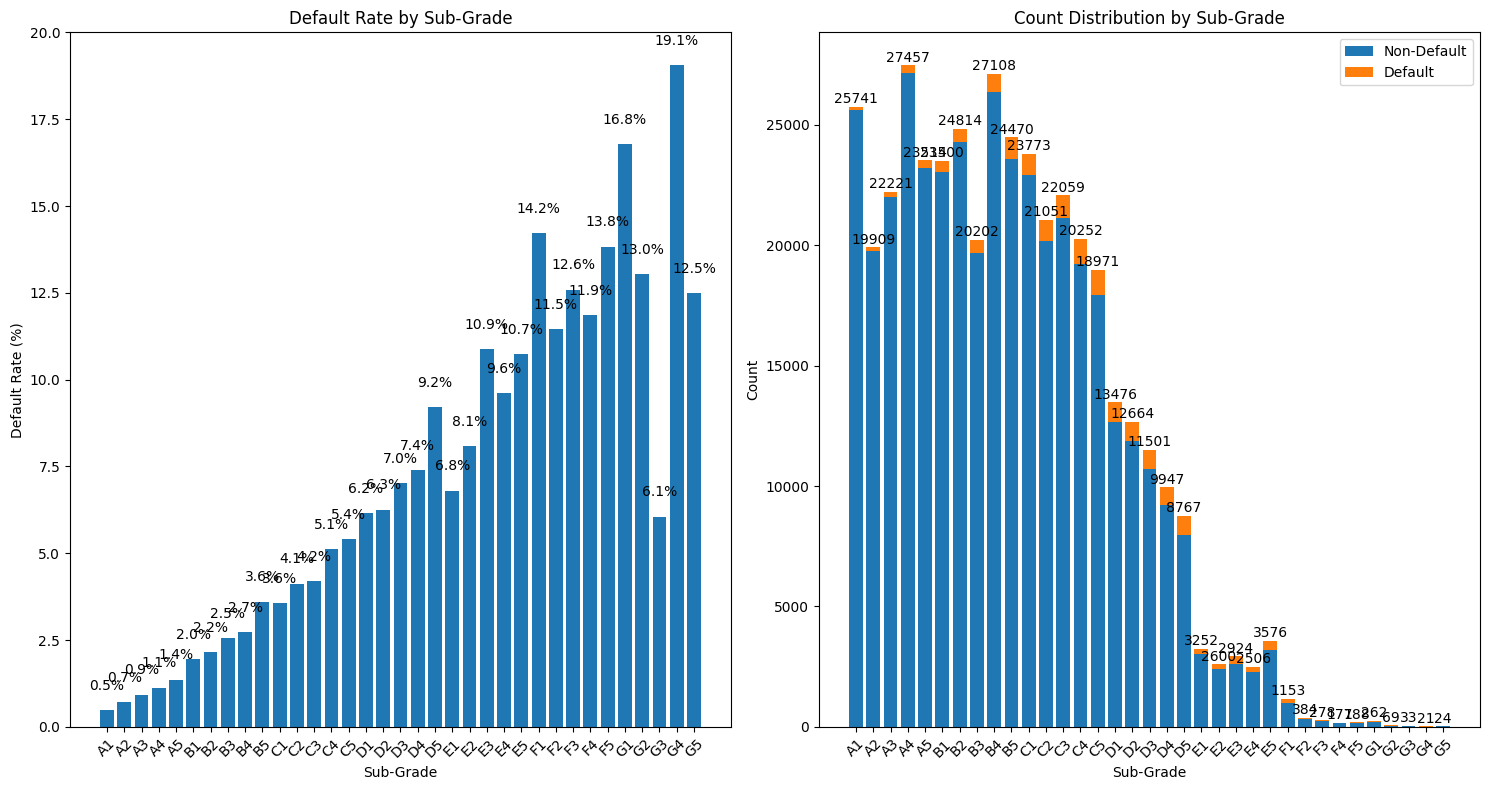

In [ ]:
def analyze_default_rates(df):
    """세부등급별 부도율 분석"""

    # 서브등급 순서 정의
    grade_order = []
    for main_grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for sub_grade in range(1, 6):
            grade_order.append(f'{main_grade}{sub_grade}')

    # 서브등급별 부도율 계산
    default_rates = df.groupby('actual_subgrade')['actual_default'].agg([
        ('default_count', 'sum'),
        ('total_count', 'count'),
        ('default_rate', 'mean')
    ]).round(4)

    # 순서대로 정렬
    default_rates = default_rates.reindex(grade_order)

    # 부도율을 퍼센트로 변환
    default_rates['default_rate_pct'] = default_rates['default_rate'] * 100

    return default_rates

def plot_default_rates(default_rates, figsize=(15, 8)):
    """부도율 시각화"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. 부도율 막대 그래프
    ax1.bar(range(len(default_rates)), default_rates['default_rate_pct'])
    ax1.set_xticks(range(len(default_rates)))
    ax1.set_xticklabels(default_rates.index, rotation=45)
    ax1.set_title('Default Rate by Sub-Grade')
    ax1.set_xlabel('Sub-Grade')
    ax1.set_ylabel('Default Rate (%)')

    # 각 막대 위에 값 표시
    for i, v in enumerate(default_rates['default_rate_pct']):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    # 2. 건수 분포 (스택 막대 그래프)
    non_default_counts = default_rates['total_count'] - default_rates['default_count']

    ax2.bar(range(len(default_rates)), non_default_counts, label='Non-Default')
    ax2.bar(range(len(default_rates)), default_rates['default_count'],
            bottom=non_default_counts, label='Default')

    ax2.set_xticks(range(len(default_rates)))
    ax2.set_xticklabels(default_rates.index, rotation=45)
    ax2.set_title('Count Distribution by Sub-Grade')
    ax2.set_xlabel('Sub-Grade')
    ax2.set_ylabel('Count')
    ax2.legend()

    # 각 막대 위에 전체 건수 표시
    for i, total in enumerate(default_rates['total_count']):
        ax2.text(i, total + 30, str(total), ha='center', va='bottom')

    plt.tight_layout()
    return fig

# 분석 실행
default_rates = analyze_default_rates(comparison_df)

# 결과 출력
print("\n세부등급별 부도율:")
print(default_rates[['total_count', 'default_count', 'default_rate_pct']].round(2))

# 시각화
plot_default_rates(default_rates)
plt.show()

## 기존 등급과 새로운 등급
    # 세부등급별 평균 부도율
    grade_boundaries = {
        'A1': 0.050, 'A2': 0.051, 'A3': 0.058, 'A4': 0.065, 'A5': 0.073,
        'B1': 0.079, 'B2': 0.087, 'B3': 0.094, 'B4': 0.099, 'B5': 0.106,
        'C1': 0.115, 'C2': 0.122, 'C3': 0.128, 'C4': 0.135, 'C5': 0.142,
        'D1': 0.146, 'D2': 0.152, 'D3': 0.159, 'D4': 0.165, 'D5': 0.175,
        'E1': 0.144, 'E2': 0.159, 'E3': 0.189, 'E4': 0.193, 'E5': 0.202,
        'F1': 0.225, 'F2': 0.194, 'F3': 0.203, 'F4': 0.188, 'F5': 0.199,
        'G1': 0.192, 'G2': 0.151, 'G3': 0.218, 'G4': 0.231, 'G5': 0.205
    }
    
    # 이자율 정보
    interest_rates = {
        'A1': 5.85, 'A2': 6.44, 'A3': 7.02, 'A4': 7.70, 'A5': 8.31,
        'B1': 9.79, 'B2': 10.25, 'B3': 10.79, 'B4': 11.31, 'B5': 12.39,
        'C1': 13.14, 'C2': 14.07, 'C3': 14.62, 'C4': 15.63, 'C5': 16.51,
        'D1': 17.68, 'D2': 18.65, 'D3': 19.62, 'D4': 20.58, 'D5': 22.02,
        'E1': 23.26, 'E2': 24.16, 'E3': 25.09, 'E4': 26.06, 'E5': 27.00,
        'F1': 28.70, 'F2': 29.69, 'F3': 30.17, 'F4': 30.65, 'F5': 30.75,
        'G1': 30.79, 'G2': 30.84, 'G3': 30.89, 'G4': 30.94, 'G5': 30.99
    }

<ipython-input-44-839def6d1690>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_default_rates = df.groupby('predicted_subgrade')['actual_default'].agg([



실제 세부등급별 부도율:
actual_subgrade
A1     0.49
A2     0.72
A3     0.93
A4     1.13
A5     1.36
B1     1.96
B2     2.16
B3     2.55
B4     2.72
B5     3.61
C1     3.56
C2     4.13
C3     4.19
C4     5.12
C5     5.41
D1     6.16
D2     6.26
D3     7.02
D4     7.40
D5     9.20
E1     6.80
E2     8.08
E3    10.88
E4     9.62
E5    10.74
F1    14.22
F2    11.46
F3    12.59
F4    11.86
F5    13.83
G1    16.79
G2    13.04
G3     6.06
G4    19.05
G5    12.50
Name: default_rate, dtype: float64

예측 세부등급별 부도율:
predicted_subgrade
A1     0.00
A2     0.00
A3     0.00
A4     0.30
A5     0.27
B1     0.28
B2     0.22
B3     0.33
B4     0.56
B5     0.64
C1     0.67
C2     0.87
C3     1.08
C4     1.12
C5     1.43
D1     1.68
D2     1.82
D3     2.08
D4     2.68
D5     2.92
E1     3.54
E2     4.00
E3     4.85
E4     5.38
E5     6.17
F1     7.45
F2     8.22
F3     9.23
F4    11.03
F5    12.14
G1    15.94
G2    13.93
G3    19.74
G4    26.29
G5    16.00
Name: default_rate, dtype: float64


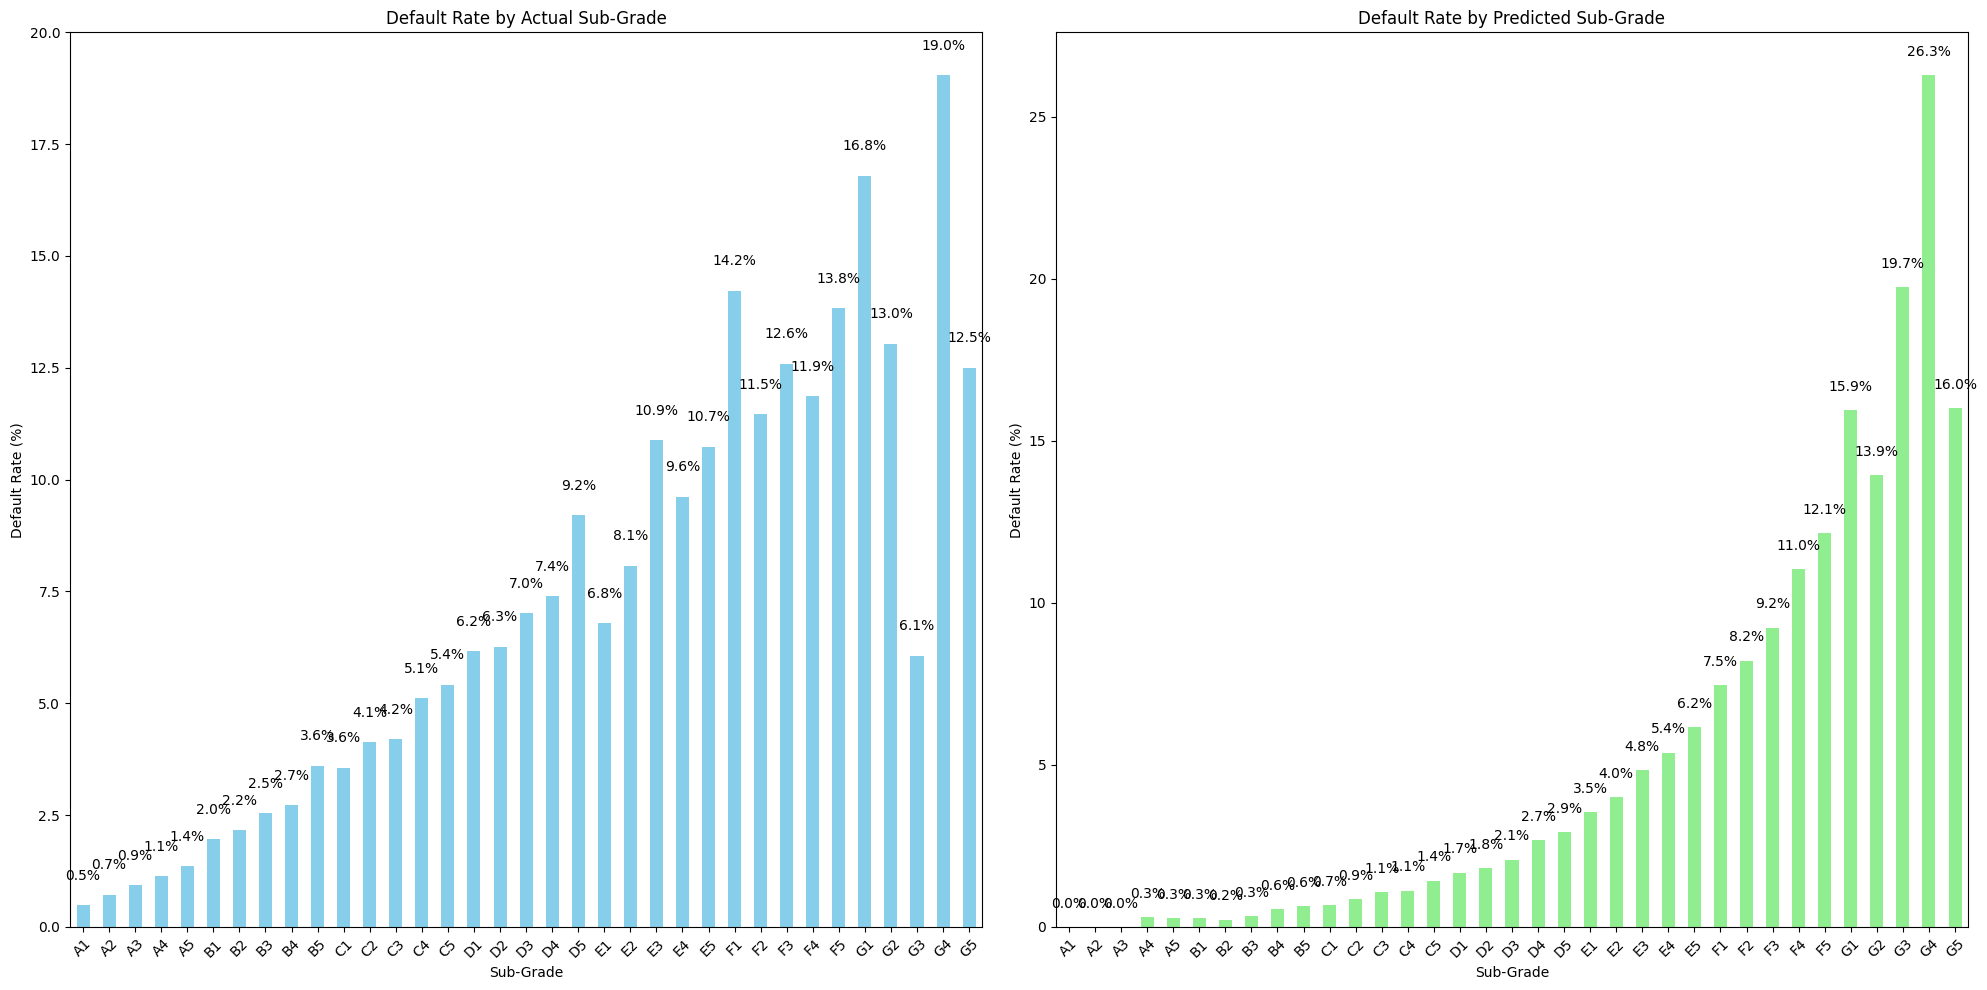

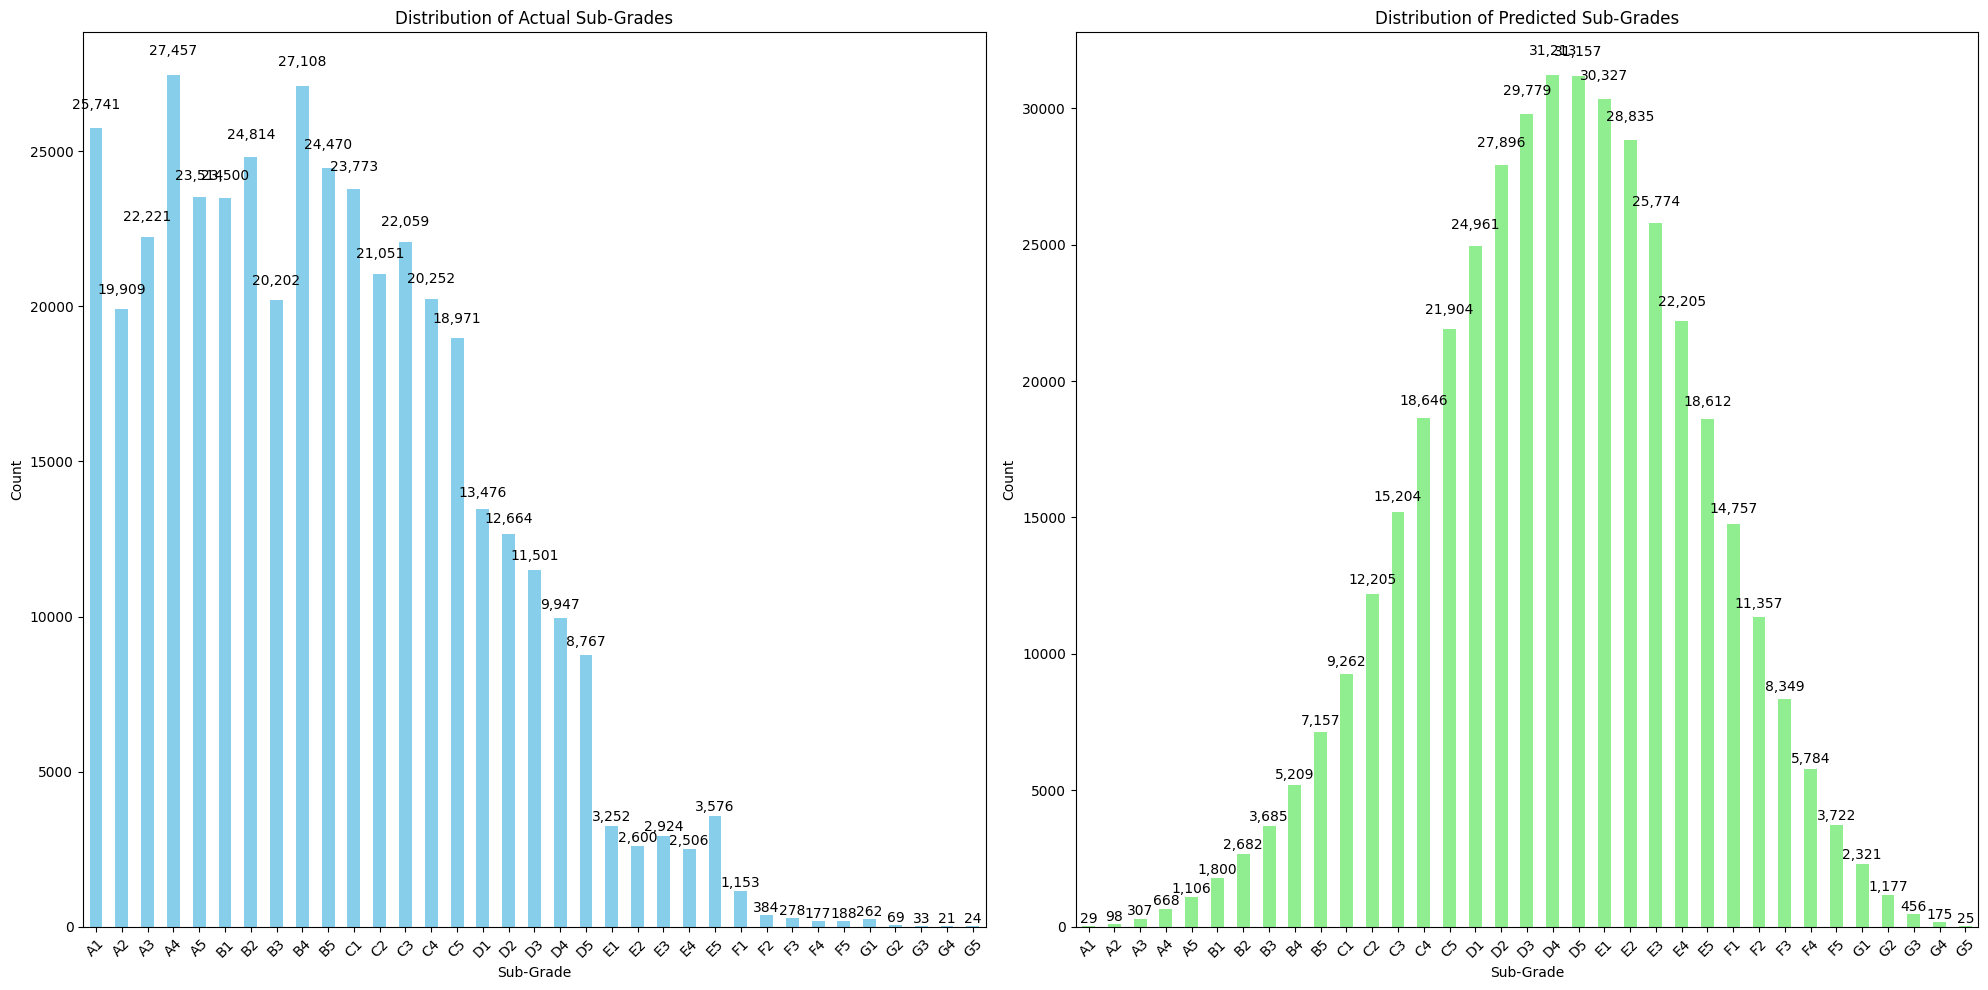

In [ ]:
def create_predicted_subgrades(default_probabilities, num_subgrades=35):
    """예측 확률을 기반으로 세부 신용등급 생성"""

    # 로그 스케일로 확률 구간 생성
    log_probs = np.log(default_probabilities)
    prob_ranges = np.exp(np.linspace(np.min(log_probs), np.max(log_probs), num_subgrades + 1))

    # 세부등급 레이블 생성
    subgrade_labels = []
    for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for num in range(1, 6):
            subgrade_labels.append(f'{grade}{num}')

    # 세부등급 할당
    predicted_subgrades = pd.cut(default_probabilities,
                                bins=prob_ranges,
                                labels=subgrade_labels,
                                include_lowest=True)

    return predicted_subgrades, prob_ranges

def analyze_subgrade_default_rates(df, actual_defaults):
    """세부등급별 부도율 분석"""

    # 실제 세부등급의 부도율
    actual_default_rates = df.groupby('actual_subgrade')['actual_default'].agg([
        ('default_count', 'sum'),
        ('total_count', 'count'),
        ('default_rate', 'mean')
    ])

    # 예측 세부등급의 부도율
    predicted_default_rates = df.groupby('predicted_subgrade')['actual_default'].agg([
        ('default_count', 'sum'),
        ('total_count', 'count'),
        ('default_rate', 'mean')
    ])

    return actual_default_rates, predicted_default_rates

def plot_subgrade_comparison(actual_rates, predicted_rates, figsize=(20, 10)):
    """세부등급 부도율 비교 시각화"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. 실제 세부등급 부도율
    actual_rates['default_rate'].mul(100).plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Default Rate by Actual Sub-Grade')
    ax1.set_xlabel('Sub-Grade')
    ax1.set_ylabel('Default Rate (%)')
    ax1.tick_params(axis='x', rotation=45)

    # 부도율 값 표시
    for i, v in enumerate(actual_rates['default_rate']):
        ax1.text(i, v*100 + 0.5, f'{v*100:.1f}%', ha='center', va='bottom')

    # 2. 예측 세부등급 부도율
    predicted_rates['default_rate'].mul(100).plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Default Rate by Predicted Sub-Grade')
    ax2.set_xlabel('Sub-Grade')
    ax2.set_ylabel('Default Rate (%)')
    ax2.tick_params(axis='x', rotation=45)

    # 부도율 값 표시
    for i, v in enumerate(predicted_rates['default_rate']):
        ax2.text(i, v*100 + 0.5, f'{v*100:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    return fig

def create_subgrade_distribution_plot(actual_rates, predicted_rates, figsize=(20, 10)):
    """세부등급별 분포 비교 시각화"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. 실제 세부등급 분포
    actual_rates['total_count'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Distribution of Actual Sub-Grades')
    ax1.set_xlabel('Sub-Grade')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    # 건수 표시
    for i, v in enumerate(actual_rates['total_count']):
        ax1.text(i, v + v*0.02, f'{int(v):,}', ha='center', va='bottom')

    # 2. 예측 세부등급 분포
    predicted_rates['total_count'].plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Distribution of Predicted Sub-Grades')
    ax2.set_xlabel('Sub-Grade')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    # 건수 표시
    for i, v in enumerate(predicted_rates['total_count']):
        ax2.text(i, v + v*0.02, f'{int(v):,}', ha='center', va='bottom')

    plt.tight_layout()
    return fig


# 예측 세부등급 생성
predicted_subgrades, prob_ranges = create_predicted_subgrades(comparison_df['default_probability'])

# 데이터프레임 업데이트
comparison_df['predicted_subgrade'] = predicted_subgrades

# 부도율 분석
actual_default_rates, predicted_default_rates = analyze_subgrade_default_rates(
    comparison_df,
    comparison_df['actual_default']
)

# 결과 출력
print("\n실제 세부등급별 부도율:")
print(actual_default_rates['default_rate'].mul(100).round(2))

print("\n예측 세부등급별 부도율:")
print(predicted_default_rates['default_rate'].mul(100).round(2))

# 부도율 비교 시각화
plot_subgrade_comparison(actual_default_rates, predicted_default_rates)
plt.show()

# 분포 비교 시각화
create_subgrade_distribution_plot(actual_default_rates, predicted_default_rates)
plt.show()

<ipython-input-45-c8e072a56f23>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_int_rates = comparison_df.groupby('predicted_subgrade')['int_rate'].mean()


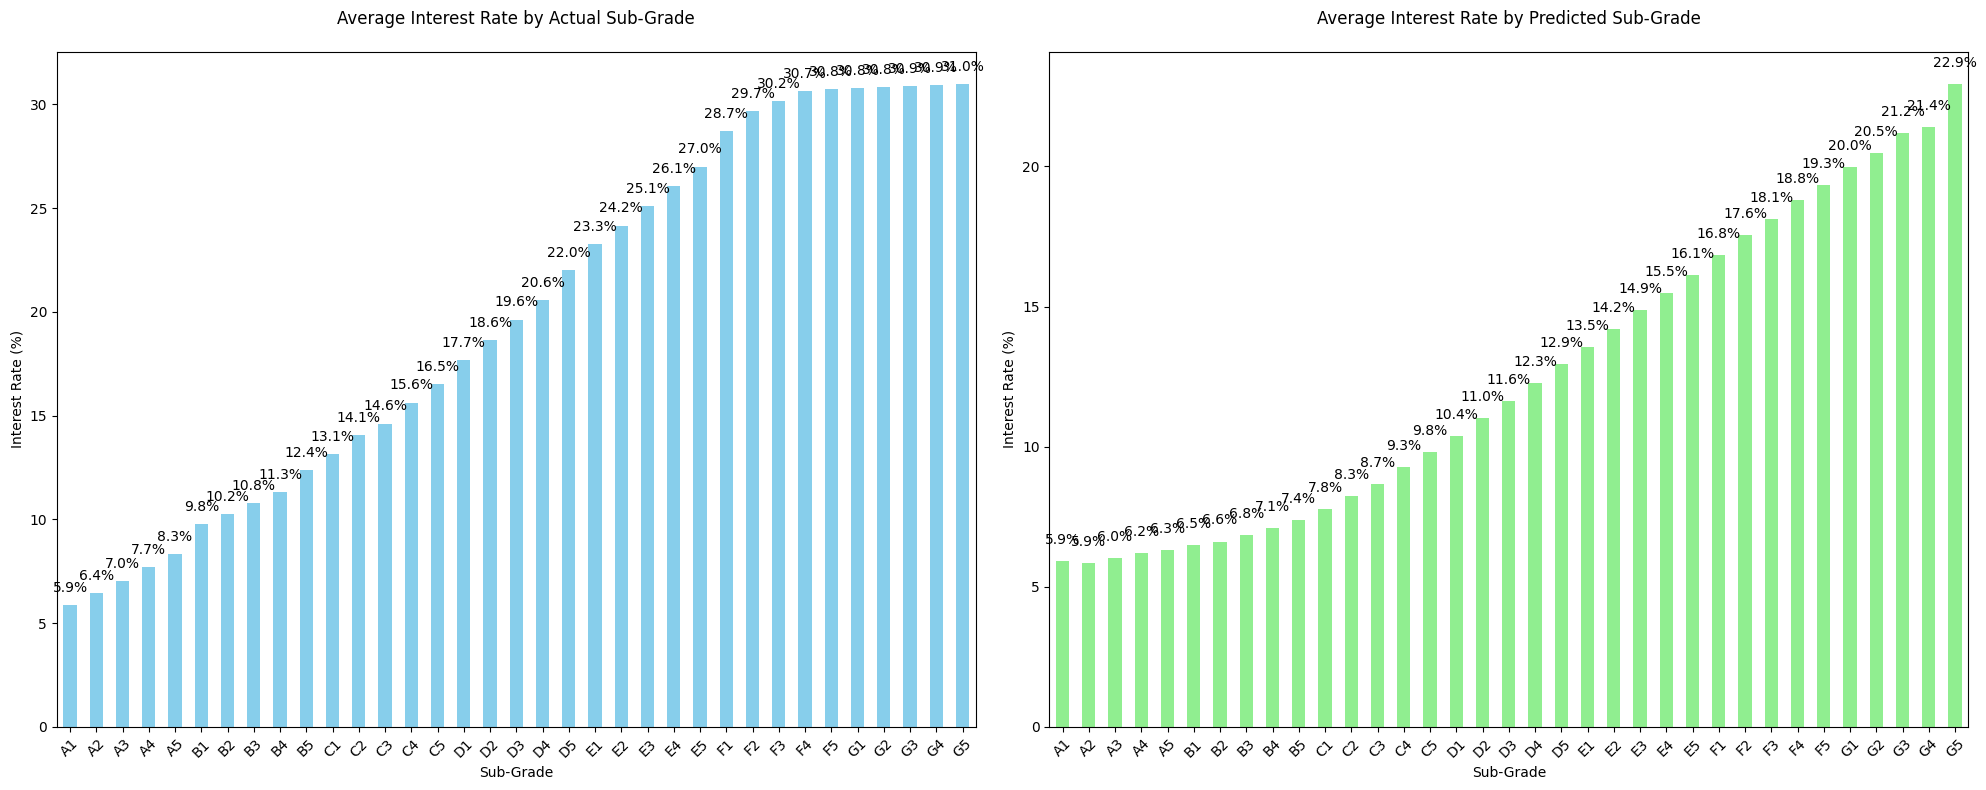


실제 세부등급별 평균 이자율:
actual_subgrade
A1     5.85
A2     6.44
A3     7.02
A4     7.70
A5     8.31
B1     9.79
B2    10.25
B3    10.79
B4    11.31
B5    12.39
C1    13.14
C2    14.07
C3    14.62
C4    15.63
C5    16.51
D1    17.68
D2    18.65
D3    19.62
D4    20.58
D5    22.02
E1    23.26
E2    24.16
E3    25.09
E4    26.06
E5    27.00
F1    28.70
F2    29.69
F3    30.17
F4    30.65
F5    30.75
G1    30.79
G2    30.84
G3    30.89
G4    30.94
G5    30.99
Name: int_rate, dtype: float64

예측 세부등급별 평균 이자율:
predicted_subgrade
A1     5.91
A2     5.86
A3     6.02
A4     6.19
A5     6.30
B1     6.48
B2     6.62
B3     6.83
B4     7.11
B5     7.38
C1     7.78
C2     8.25
C3     8.66
C4     9.27
C5     9.81
D1    10.40
D2    11.01
D3    11.64
D4    12.27
D5    12.94
E1    13.55
E2    14.20
E3    14.88
E4    15.50
E5    16.13
F1    16.84
F2    17.56
F3    18.13
F4    18.79
F5    19.33
G1    19.99
G2    20.46
G3    21.19
G4    21.40
G5    22.94
Name: int_rate, dtype: float64


<ipython-input-45-c8e072a56f23>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(comparison_df.groupby('predicted_subgrade')['int_rate'].mean().round(2))


In [ ]:
def plot_interest_rate_comparison(comparison_df, figsize=(20, 8)):
    """실제 및 예측 세부등급별 평균 이자율 비교"""

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 등급 순서 설정
    subgrade_order = []
    for main_grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for num in range(1, 6):
            subgrade_order.append(f'{main_grade}{num}')

    # 1. 실제 세부등급별 평균 이자율
    actual_int_rates = comparison_df.groupby('actual_subgrade')['int_rate'].mean()
    actual_int_rates = actual_int_rates.reindex(subgrade_order)
    actual_int_rates.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Average Interest Rate by Actual Sub-Grade', pad=20)
    axes[0].set_xlabel('Sub-Grade')
    axes[0].set_ylabel('Interest Rate (%)')
    axes[0].tick_params(axis='x', rotation=45)

    # 이자율 값 표시
    for i, v in enumerate(actual_int_rates):
        axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    # 2. 예측 세부등급별 평균 이자율
    predicted_int_rates = comparison_df.groupby('predicted_subgrade')['int_rate'].mean()
    predicted_int_rates = predicted_int_rates.reindex(subgrade_order)
    predicted_int_rates.plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('Average Interest Rate by Predicted Sub-Grade', pad=20)
    axes[1].set_xlabel('Sub-Grade')
    axes[1].set_ylabel('Interest Rate (%)')
    axes[1].tick_params(axis='x', rotation=45)

    # 이자율 값 표시
    for i, v in enumerate(predicted_int_rates):
        axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    return fig

# 시각화 실행
plot_interest_rate_comparison(comparison_df)
plt.show()

# 이자율 통계 출력
print("\n실제 세부등급별 평균 이자율:")
print(comparison_df.groupby('actual_subgrade')['int_rate'].mean().round(2))

print("\n예측 세부등급별 평균 이자율:")
print(comparison_df.groupby('predicted_subgrade')['int_rate'].mean().round(2))

<ipython-input-46-a729192121ef>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_default_rates = df.groupby('predicted_subgrade')['actual_default'].agg([



실제 세부등급별 부도율:
actual_subgrade
A1     0.49
A2     0.72
A3     0.93
A4     1.13
A5     1.36
B1     1.96
B2     2.16
B3     2.55
B4     2.72
B5     3.61
C1     3.56
C2     4.13
C3     4.19
C4     5.12
C5     5.41
D1     6.16
D2     6.26
D3     7.02
D4     7.40
D5     9.20
E1     6.80
E2     8.08
E3    10.88
E4     9.62
E5    10.74
F1    14.22
F2    11.46
F3    12.59
F4    11.86
F5    13.83
G1    16.79
G2    13.04
G3     6.06
G4    19.05
G5    12.50
Name: default_rate, dtype: float64

예측 세부등급별 부도율:
predicted_subgrade
A1     0.63
A2     1.09
A3     1.31
A4     1.61
A5     1.71
B1     1.96
B2     2.30
B3     2.72
B4     2.90
B5     3.29
C1     3.71
C2     4.08
C3     4.86
C4     5.26
C5     5.80
D1     6.27
D2     7.61
D3     7.99
D4     8.84
D5     8.73
E1     9.58
E2    11.90
E3    12.33
E4    13.28
E5    15.52
F1    14.06
F2    15.83
F3    16.95
F4    20.21
F5    20.99
G1    21.74
G2    39.39
G3    19.05
G4    16.67
G5      NaN
Name: default_rate, dtype: float64


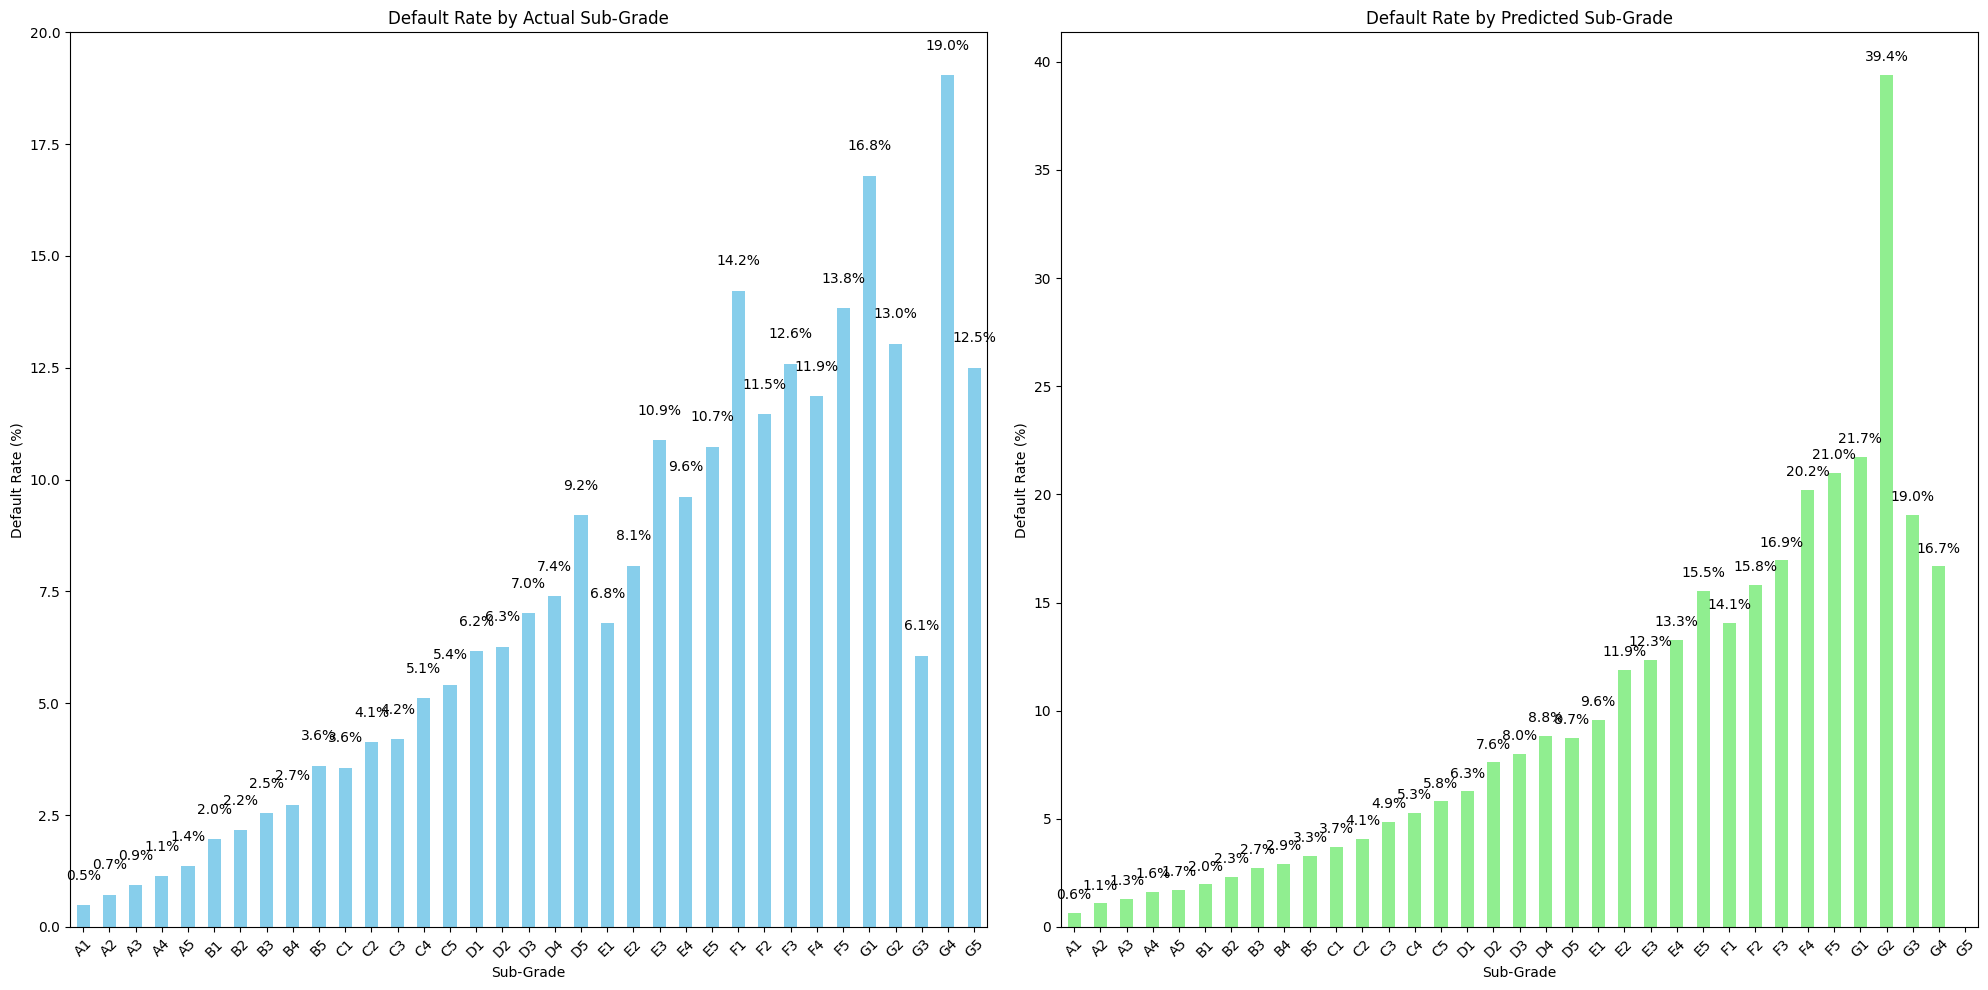

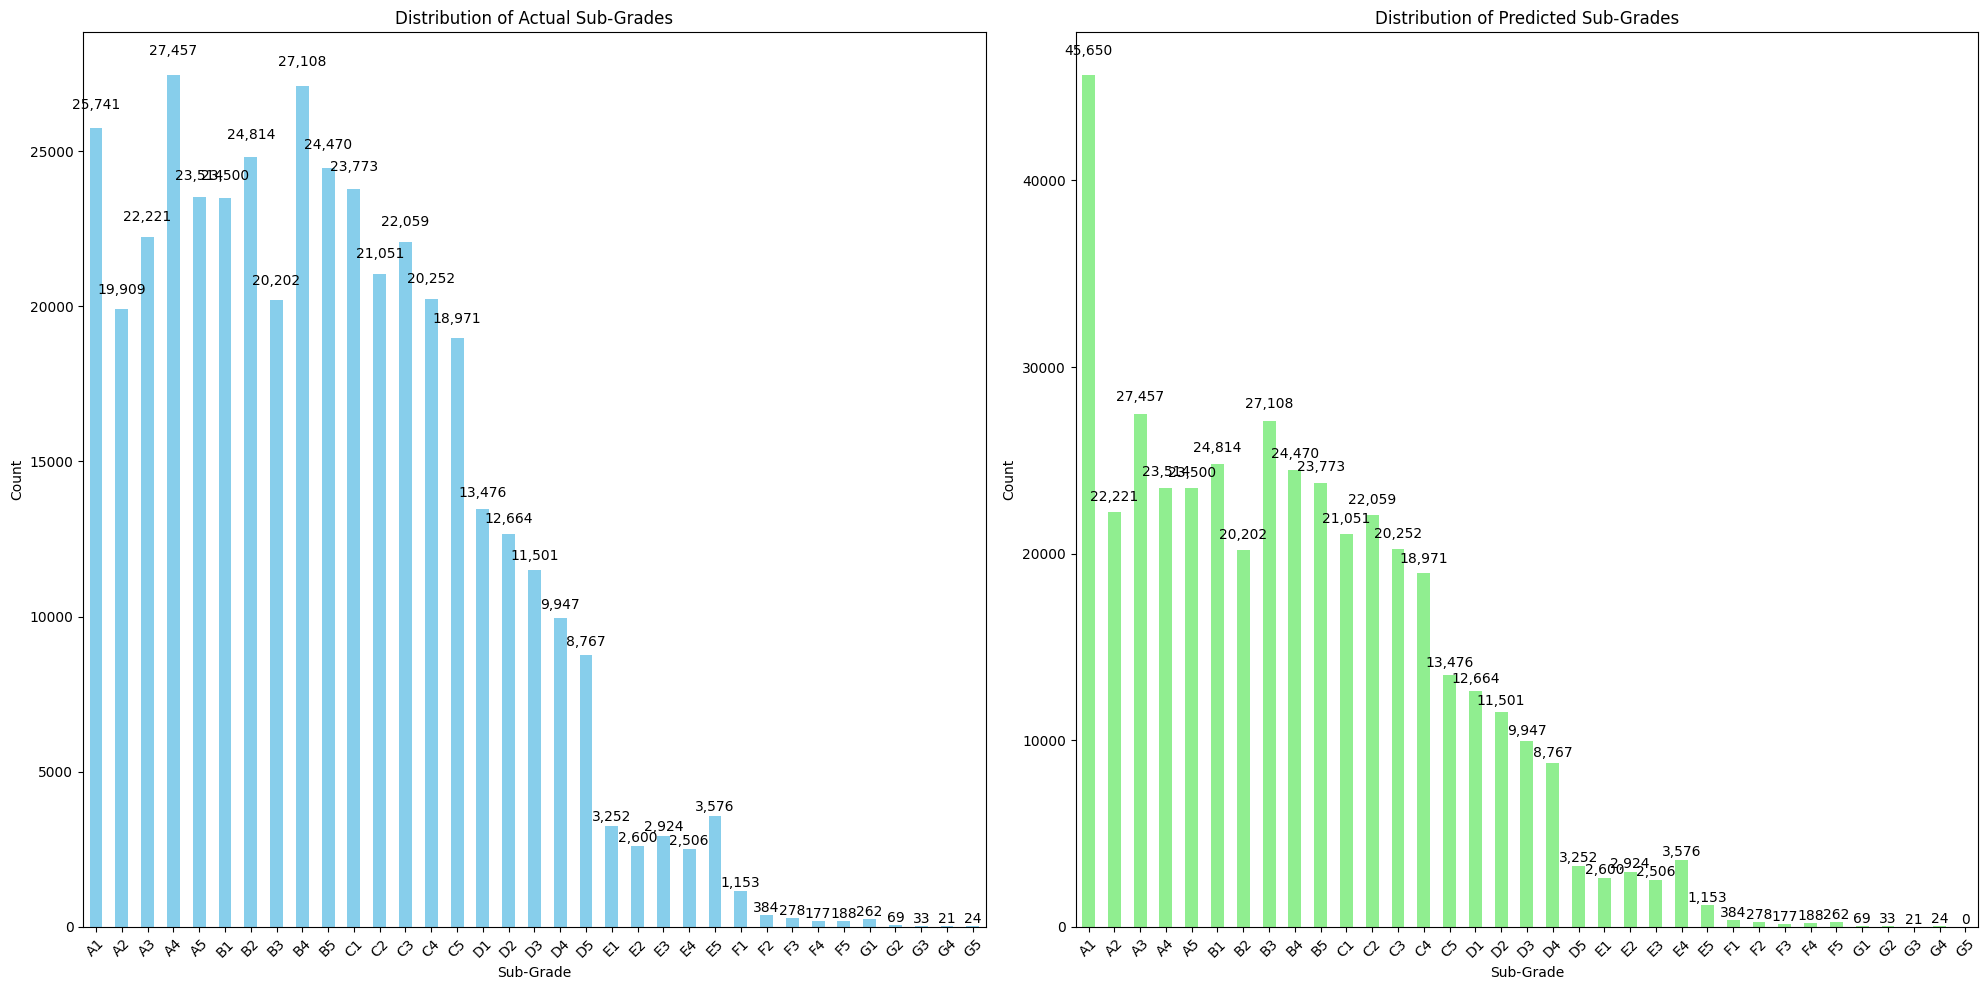

In [ ]:
def create_predicted_subgrades(default_probabilities, actual_subgrades):
    """예측 확률을 기반으로 세부 신용등급 생성"""

    # 세부등급 레이블 생성
    subgrade_labels = []
    for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for num in range(1, 6):
            subgrade_labels.append(f'{grade}{num}')

    # 실제 등급의 분포 비율 계산
    actual_dist = pd.Series(actual_subgrades).value_counts(normalize=True)
    actual_dist = actual_dist.reindex(subgrade_labels)

    # 누적 분포 계산
    cumulative_dist = actual_dist.cumsum()

    # 분위수 기반으로 경계값 설정
    prob_ranges = []
    for percent in cumulative_dist:
        boundary = np.percentile(default_probabilities, percent * 100)
        prob_ranges.append(boundary)

    # 시작점과 끝점 보정
    prob_ranges[0] = default_probabilities.min() * 0.99  # 최소값보다 약간 작은 값
    prob_ranges.append(default_probabilities.max() * 1.01)  # 최대값보다 약간 큰 값

    # 세부등급 할당
    predicted_subgrades = pd.cut(default_probabilities,
                                bins=prob_ranges,
                                labels=subgrade_labels,
                                include_lowest=True)

    return predicted_subgrades, prob_ranges

def analyze_subgrade_default_rates(df, actual_defaults):
    """세부등급별 부도율 분석"""

    # 실제 세부등급의 부도율
    actual_default_rates = df.groupby('actual_subgrade')['actual_default'].agg([
        ('default_count', 'sum'),
        ('total_count', 'count'),
        ('default_rate', 'mean')
    ])

    # 예측 세부등급의 부도율
    predicted_default_rates = df.groupby('predicted_subgrade')['actual_default'].agg([
        ('default_count', 'sum'),
        ('total_count', 'count'),
        ('default_rate', 'mean')
    ])

    return actual_default_rates, predicted_default_rates

def plot_subgrade_comparison(actual_rates, predicted_rates, figsize=(20, 10)):
    """세부등급 부도율 비교 시각화"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. 실제 세부등급 부도율
    actual_rates['default_rate'].mul(100).plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Default Rate by Actual Sub-Grade')
    ax1.set_xlabel('Sub-Grade')
    ax1.set_ylabel('Default Rate (%)')
    ax1.tick_params(axis='x', rotation=45)

    # 부도율 값 표시
    for i, v in enumerate(actual_rates['default_rate']):
        ax1.text(i, v*100 + 0.5, f'{v*100:.1f}%', ha='center', va='bottom')

    # 2. 예측 세부등급 부도율
    predicted_rates['default_rate'].mul(100).plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Default Rate by Predicted Sub-Grade')
    ax2.set_xlabel('Sub-Grade')
    ax2.set_ylabel('Default Rate (%)')
    ax2.tick_params(axis='x', rotation=45)

    # 부도율 값 표시
    for i, v in enumerate(predicted_rates['default_rate']):
        ax2.text(i, v*100 + 0.5, f'{v*100:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    return fig

def create_subgrade_distribution_plot(actual_rates, predicted_rates, figsize=(20, 10)):
    """세부등급별 분포 비교 시각화"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. 실제 세부등급 분포
    actual_rates['total_count'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Distribution of Actual Sub-Grades')
    ax1.set_xlabel('Sub-Grade')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    # 건수 표시
    for i, v in enumerate(actual_rates['total_count']):
        ax1.text(i, v + v*0.02, f'{int(v):,}', ha='center', va='bottom')

    # 2. 예측 세부등급 분포
    predicted_rates['total_count'].plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Distribution of Predicted Sub-Grades')
    ax2.set_xlabel('Sub-Grade')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    # 건수 표시
    for i, v in enumerate(predicted_rates['total_count']):
        ax2.text(i, v + v*0.02, f'{int(v):,}', ha='center', va='bottom')

    plt.tight_layout()
    return fig

# 예측 세부등급 생성
predicted_subgrades, prob_ranges = create_predicted_subgrades(
    comparison_df['default_probability'],
    comparison_df['actual_subgrade']
)

# 데이터프레임 업데이트
comparison_df['predicted_subgrade'] = predicted_subgrades

# 부도율 분석
actual_default_rates, predicted_default_rates = analyze_subgrade_default_rates(
    comparison_df,
    comparison_df['actual_default']
)

# 결과 출력
print("\n실제 세부등급별 부도율:")
print(actual_default_rates['default_rate'].mul(100).round(2))

print("\n예측 세부등급별 부도율:")
print(predicted_default_rates['default_rate'].mul(100).round(2))

# 부도율 비교 시각화
plot_subgrade_comparison(actual_default_rates, predicted_default_rates)
plt.show()

# 분포 비교 시각화
create_subgrade_distribution_plot(actual_default_rates, predicted_default_rates)
plt.show()

<ipython-input-47-c8e072a56f23>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_int_rates = comparison_df.groupby('predicted_subgrade')['int_rate'].mean()


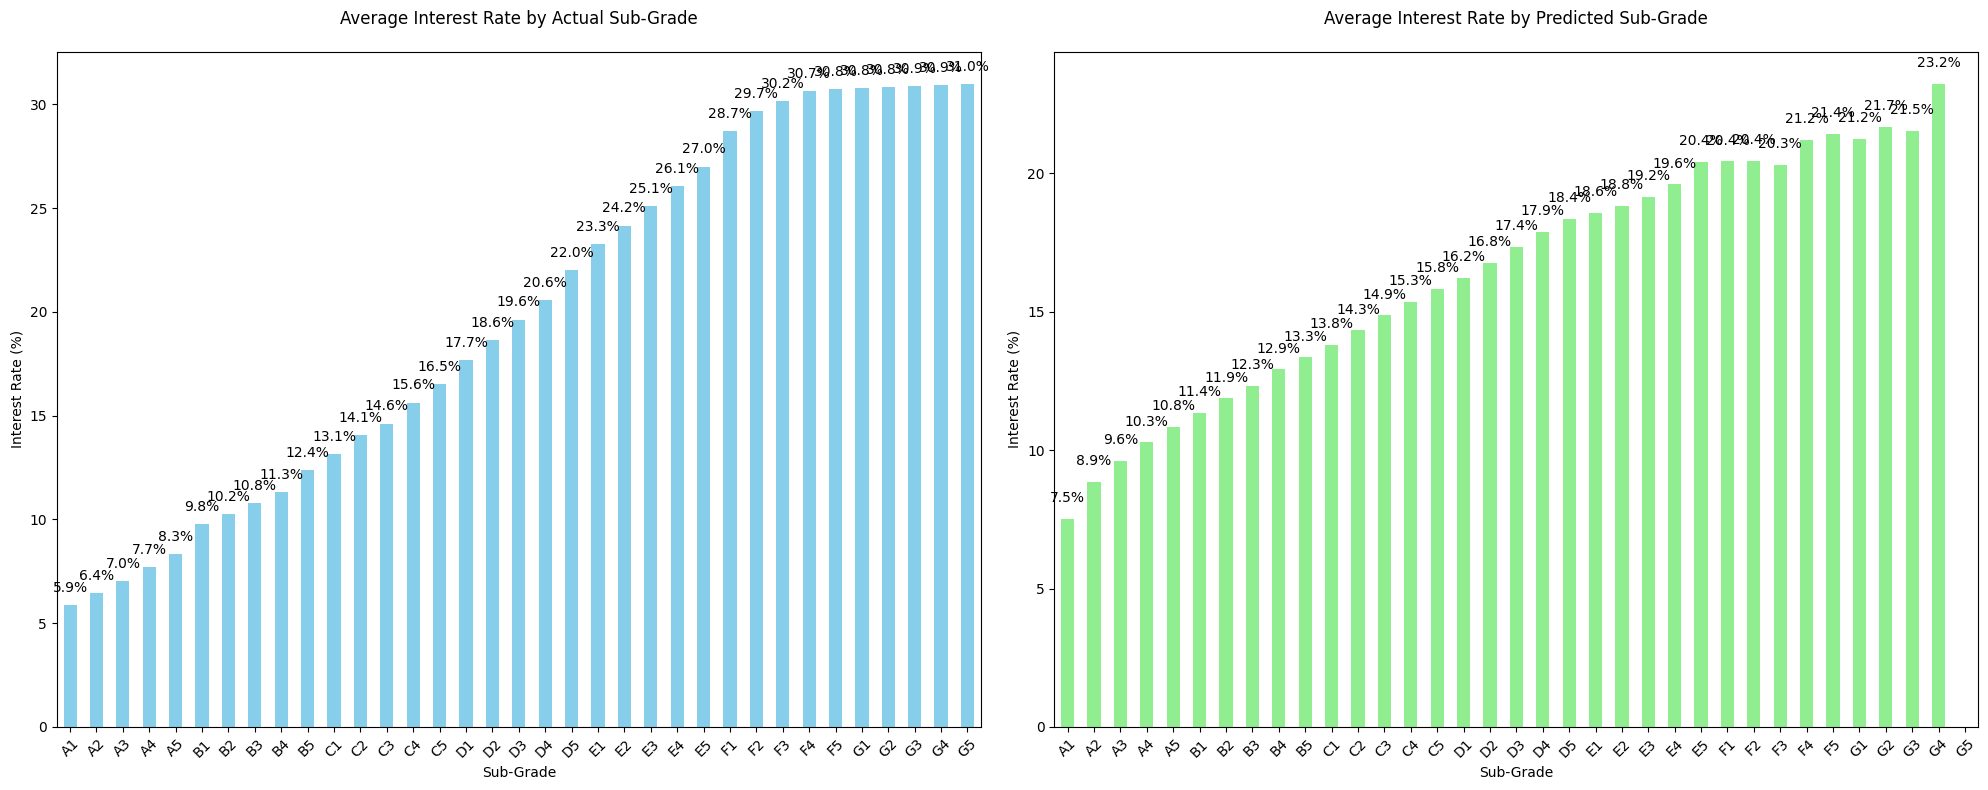


실제 세부등급별 평균 이자율:
actual_subgrade
A1     5.85
A2     6.44
A3     7.02
A4     7.70
A5     8.31
B1     9.79
B2    10.25
B3    10.79
B4    11.31
B5    12.39
C1    13.14
C2    14.07
C3    14.62
C4    15.63
C5    16.51
D1    17.68
D2    18.65
D3    19.62
D4    20.58
D5    22.02
E1    23.26
E2    24.16
E3    25.09
E4    26.06
E5    27.00
F1    28.70
F2    29.69
F3    30.17
F4    30.65
F5    30.75
G1    30.79
G2    30.84
G3    30.89
G4    30.94
G5    30.99
Name: int_rate, dtype: float64

예측 세부등급별 평균 이자율:
predicted_subgrade
A1     7.52
A2     8.86
A3     9.60
A4    10.28
A5    10.83
B1    11.35
B2    11.86
B3    12.32
B4    12.91
B5    13.34
C1    13.81
C2    14.32
C3    14.86
C4    15.34
C5    15.83
D1    16.23
D2    16.78
D3    17.35
D4    17.87
D5    18.36
E1    18.57
E2    18.81
E3    19.15
E4    19.60
E5    20.41
F1    20.43
F2    20.44
F3    20.29
F4    21.22
F5    21.41
G1    21.25
G2    21.68
G3    21.52
G4    23.22
G5      NaN
Name: int_rate, dtype: float64


<ipython-input-47-c8e072a56f23>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(comparison_df.groupby('predicted_subgrade')['int_rate'].mean().round(2))


In [ ]:
def plot_interest_rate_comparison(comparison_df, figsize=(20, 8)):
    """실제 및 예측 세부등급별 평균 이자율 비교"""

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 등급 순서 설정
    subgrade_order = []
    for main_grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        for num in range(1, 6):
            subgrade_order.append(f'{main_grade}{num}')

    # 1. 실제 세부등급별 평균 이자율
    actual_int_rates = comparison_df.groupby('actual_subgrade')['int_rate'].mean()
    actual_int_rates = actual_int_rates.reindex(subgrade_order)
    actual_int_rates.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Average Interest Rate by Actual Sub-Grade', pad=20)
    axes[0].set_xlabel('Sub-Grade')
    axes[0].set_ylabel('Interest Rate (%)')
    axes[0].tick_params(axis='x', rotation=45)

    # 이자율 값 표시
    for i, v in enumerate(actual_int_rates):
        axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    # 2. 예측 세부등급별 평균 이자율
    predicted_int_rates = comparison_df.groupby('predicted_subgrade')['int_rate'].mean()
    predicted_int_rates = predicted_int_rates.reindex(subgrade_order)
    predicted_int_rates.plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('Average Interest Rate by Predicted Sub-Grade', pad=20)
    axes[1].set_xlabel('Sub-Grade')
    axes[1].set_ylabel('Interest Rate (%)')
    axes[1].tick_params(axis='x', rotation=45)

    # 이자율 값 표시
    for i, v in enumerate(predicted_int_rates):
        axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    return fig

# 시각화 실행
plot_interest_rate_comparison(comparison_df)
plt.show()

# 이자율 통계 출력
print("\n실제 세부등급별 평균 이자율:")
print(comparison_df.groupby('actual_subgrade')['int_rate'].mean().round(2))

print("\n예측 세부등급별 평균 이자율:")
print(comparison_df.groupby('predicted_subgrade')['int_rate'].mean().round(2))

In [ ]:
# 검증을 위한 코드
# 1. 전체 평균 이자율 확인
print("전체 평균 이자율:", comparison_df['int_rate'].mean())

# 2. 실제 등급별 평균 이자율의 전체 평균
actual_mean = comparison_df.groupby('actual_subgrade')['int_rate'].mean().mean()
print("실제 등급 기준 평균 이자율:", actual_mean)

# 3. 예측 등급별 평균 이자율의 전체 평균
predicted_mean = comparison_df.groupby('predicted_subgrade')['int_rate'].mean().mean()
print("예측 등급 기준 평균 이자율:", predicted_mean)

# 4. 각 등급별 데이터 수 확인
print("\n실제 등급별 데이터 수:")
print(comparison_df['actual_subgrade'].value_counts().sort_index())
print("\n예측 등급별 데이터 수:")
print(comparison_df['predicted_subgrade'].value_counts().sort_index())

전체 평균 이자율: 12.564473479386121
실제 등급 기준 평균 이자율: 19.780783867568
예측 등급 기준 평균 이자율: 16.400292559130136

실제 등급별 데이터 수:
actual_subgrade
A1    25741
A2    19909
A3    22221
A4    27457
A5    23514
B1    23500
B2    24814
B3    20202
B4    27108
B5    24470
C1    23773
C2    21051
C3    22059
C4    20252
C5    18971
D1    13476
D2    12664
D3    11501
D4     9947
D5     8767
E1     3252
E2     2600
E3     2924
E4     2506
E5     3576
F1     1153
F2      384
F3      278
F4      177
F5      188
G1      262
G2       69
G3       33
G4       21
G5       24
Name: count, dtype: int64

예측 등급별 데이터 수:
predicted_subgrade
A1    45650
A2    22221
A3    27457
A4    23514
A5    23500
B1    24814
B2    20202
B3    27108
B4    24470
B5    23773
C1    21051
C2    22059
C3    20252
C4    18971
C5    13476
D1    12664
D2    11501
D3     9947
D4     8767
D5     3252
E1     2600
E2     2924
E3     2506
E4     3576
E5     1153
F1      384
F2      278
F3      177
F4      188
F5      262
G1       69
G2       33
G3    

<ipython-input-48-2c4d47d4fbe3>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_mean = comparison_df.groupby('predicted_subgrade')['int_rate'].mean().mean()
